# Building model with deep learning 

ARIMA is one of the most classic time series forecasting models. During the modeling process, we mainly want to find 3 parameters. Auto-regression(AR) term, namly the lags of previous value; Integral(I) term for non-stationary differencing and Moving Average(MA) for error term. In this section, we will analyse time series data: its trends, sesonalities and autocorrelation. Usually at the end of the analysis, we are able to develop a seasonal ARIMA (Autoregression Integrated Moving Average) model.

Time-Series Analysis per Store Type

-Store number 2 for StoreType A
-Store number 85 for StoreType B
-Store number 1 for StoreType C
-Store number 13 for StoreType D.

It also makes sense to downsample the data from days to weeks using the resample method to see the present trends more clearly.

In [44]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings("ignore")
#Data Manipulation and Treatment

from datetime import datetime
#Plotting and Visualizations
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from scipy import stats
import itertools
 #Scikit-Learn for Modeling
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
# statistics
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

In [45]:
store=pd.read_csv("store.csv")
store.describe()
store.head()

Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1         c          a               1270.0                        9.0   
1      2         a          a                570.0                       11.0   
2      3         a          a              14130.0                       12.0   
3      4         c          c                620.0                        9.0   
4      5         a          a              29910.0                        4.0   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                    2008.0       0              NaN              NaN   
1                    2007.0       1             13.0           2010.0   
2                    2006.0       1             14.0           2011.0   
3                    2009.0       0              NaN              NaN   
4                    2015.0       0              NaN              NaN   

     PromoInterval  
0              NaN  
1  Jan,Apr,Jul,Oct  
2  Jan,Apr,Jul,Oct  
3              NaN  
4              NaN

In [46]:
train=pd.read_csv("train.csv",parse_dates = True, low_memory = False, index_col = 'Date')
train.describe()
train.head()

Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
Date                                                                       
2015-07-31      1          5   5263        555     1      1            0   
2015-07-31      2          5   6064        625     1      1            0   
2015-07-31      3          5   8314        821     1      1            0   
2015-07-31      4          5  13995       1498     1      1            0   
2015-07-31      5          5   4822        559     1      1            0   

            SchoolHoliday  
Date                       
2015-07-31              1  
2015-07-31              1  
2015-07-31              1  
2015-07-31              1  
2015-07-31              1

**A quick glimpse at the data** 

Sales: the turnover for any given day (target variable).
Customers: the number of customers on a given day.
Open: an indicator for whether the store was open: 0 = closed, 1 = open.
Promo: indicates whether a store is running a promo on that day.
StateHoliday: indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays.
SchoolHoliday: indicates if the (Store, Date) was affected by the closure of public schools.
We are dealing with time series data so it will probably serve us to extract dates for further analysis. We also have two likely correlated vaiables in the dataset, which can be combined into a new feature.

In [47]:
# data extraction

train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear

In [48]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1017209 entries, 2015-07-31 to 2013-01-01
Data columns (total 12 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Sales          1017209 non-null  int64 
 3   Customers      1017209 non-null  int64 
 4   Open           1017209 non-null  int64 
 5   Promo          1017209 non-null  int64 
 6   StateHoliday   1017209 non-null  object
 7   SchoolHoliday  1017209 non-null  int64 
 8   Year           1017209 non-null  int64 
 9   Month          1017209 non-null  int64 
 10  Day            1017209 non-null  int64 
 11  WeekOfYear     1017209 non-null  int64 
dtypes: int64(11), object(1)
memory usage: 100.9+ MB


In [49]:
train.head()

Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
Date                                                                       
2015-07-31      1          5   5263        555     1      1            0   
2015-07-31      2          5   6064        625     1      1            0   
2015-07-31      3          5   8314        821     1      1            0   
2015-07-31      4          5  13995       1498     1      1            0   
2015-07-31      5          5   4822        559     1      1            0   

            SchoolHoliday  Year  Month  Day  WeekOfYear  
Date                                                     
2015-07-31              1  2015      7   31          31  
2015-07-31              1  2015      7   31          31  
2015-07-31              1  2015      7   31          31  
2015-07-31              1  2015      7   31          31  
2015-07-31              1  2015      7   31          31

In [50]:
# adding new variable

train['SalePerCustomer'] = train['Sales']/train['Customers']
train['SalePerCustomer'].describe()

count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalePerCustomer, dtype: float64

On average customers spend about 9.50$ per day. Though there are days with Sales equal to zero.

**In this section we go through the train and store data, handle missing values and create new features for further analysis.**

In [51]:
train.isnull().sum()

Store                   0
DayOfWeek               0
Sales                   0
Customers               0
Open                    0
Promo                   0
StateHoliday            0
SchoolHoliday           0
Year                    0
Month                   0
Day                     0
WeekOfYear              0
SalePerCustomer    172869
dtype: int64

In [52]:
train.fillna(0, inplace = True)

ECDF: empirical cumulative distribution function
To get the first impression about continious variables in the data we can plot ECDF.

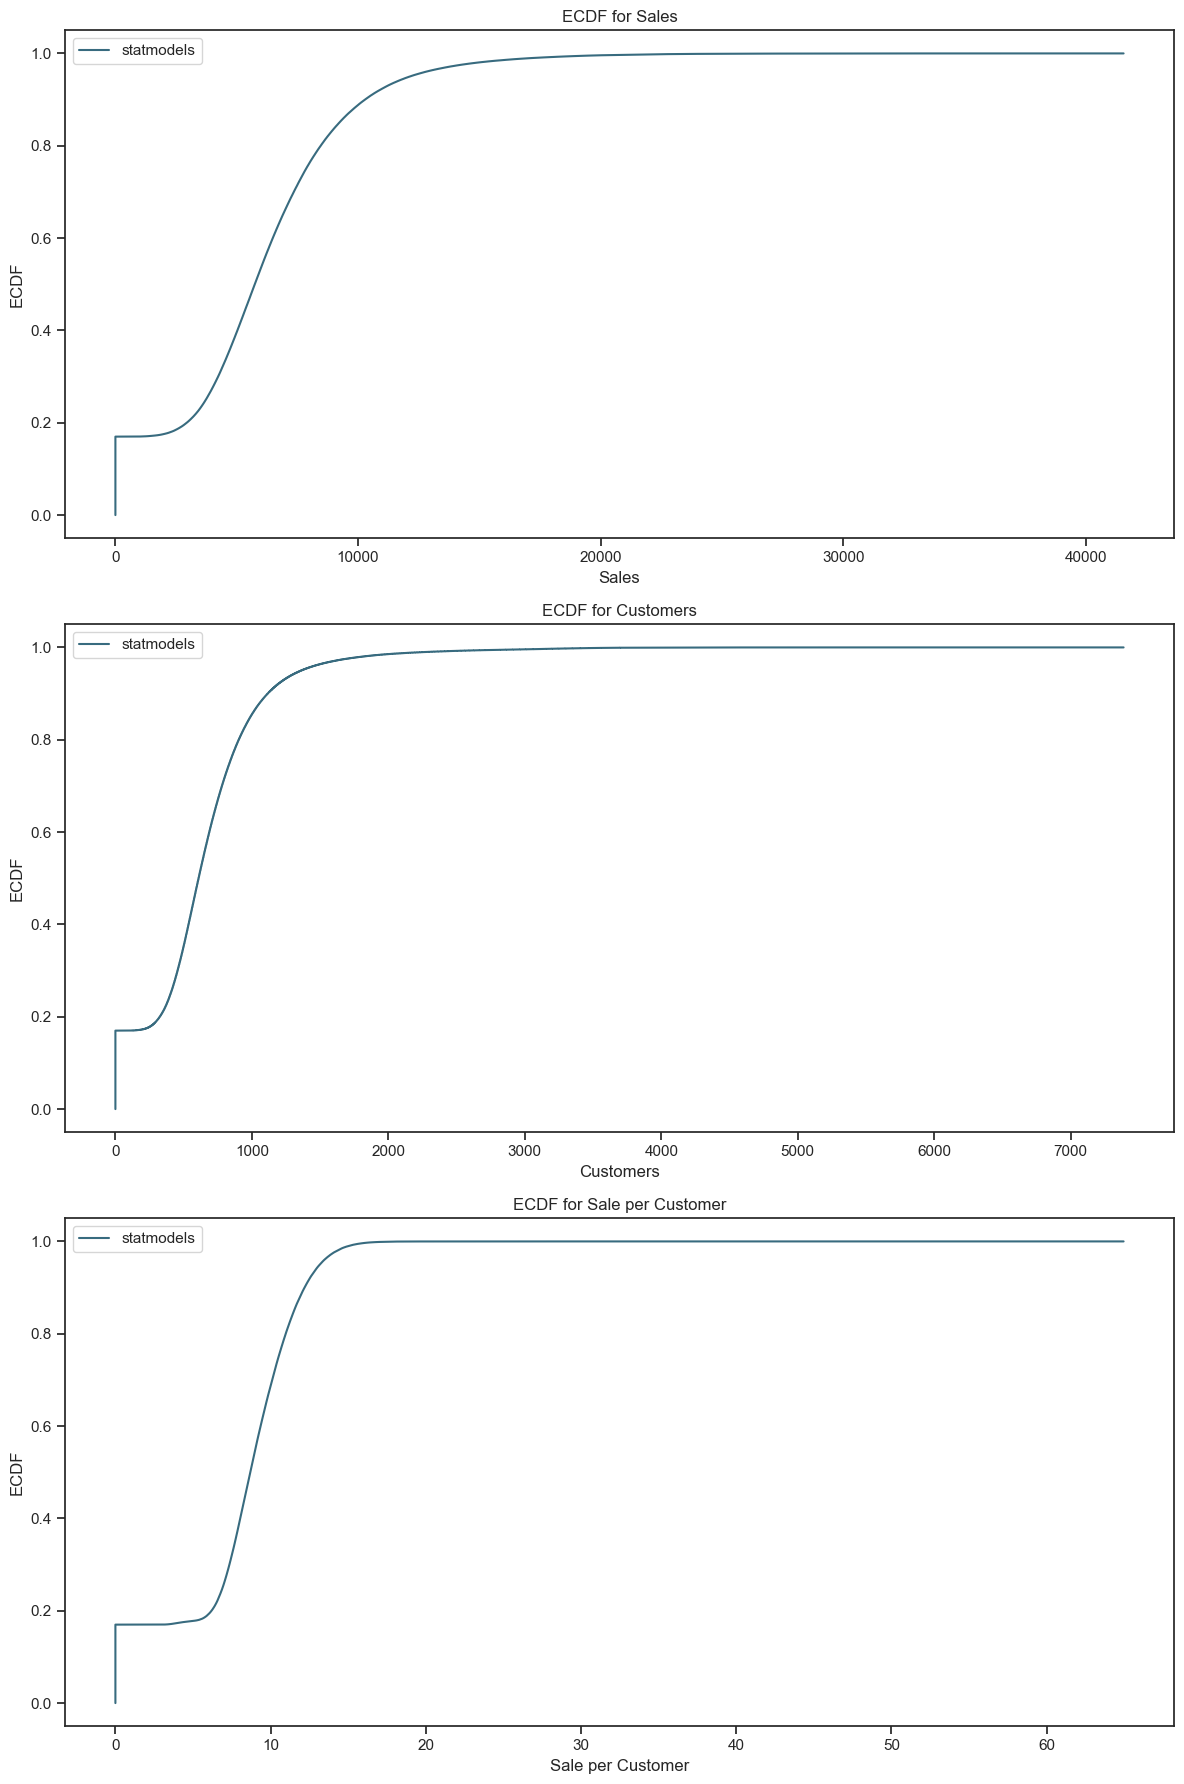

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF

# Set seaborn style
sns.set(style="ticks")

# Basic color for plots
c = '#386B7F'

# Create a figure with subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

# Plot ECDF for 'Sales'
plt.subplot(311)
cdf = ECDF(train['Sales'])
plt.plot(cdf.x, cdf.y, label="statmodels", color=c)
plt.xlabel('Sales')
plt.ylabel('ECDF')
plt.title('ECDF for Sales')
plt.legend()

# Plot ECDF for 'Customers'
plt.subplot(312)
cdf = ECDF(train['Customers'])
plt.plot(cdf.x, cdf.y, label="statmodels", color=c)
plt.xlabel('Customers')
plt.ylabel('ECDF')
plt.title('ECDF for Customers')
plt.legend()

# Plot ECDF for 'SalePerCustomer'
plt.subplot(313)
cdf = ECDF(train['SalePerCustomer'])
plt.plot(cdf.x, cdf.y, label="statmodels", color=c)
plt.xlabel('Sale per Customer')
plt.ylabel('ECDF')
plt.title('ECDF for Sale per Customer')
plt.legend()

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

About 20% of data has zero amount of sales/customers that we need to deal with and almost 80% of time daily amount of sales was less than 1000. So what about zero sales, is it only due to the fact that the store is closed

In [55]:
# closed stores
train[(train.Open == 0) & (train.Sales == 0)]

Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
Date                                                                       
2015-07-31    292          5      0          0     0      1            0   
2015-07-31    876          5      0          0     0      1            0   
2015-07-30    292          4      0          0     0      1            0   
2015-07-30    876          4      0          0     0      1            0   
2015-07-29    292          3      0          0     0      1            0   
...           ...        ...    ...        ...   ...    ...          ...   
2013-01-01   1111          2      0          0     0      0            a   
2013-01-01   1112          2      0          0     0      0            a   
2013-01-01   1113          2      0          0     0      0            a   
2013-01-01   1114          2      0          0     0      0            a   
2013-01-01   1115          2      0          0     0      0            a   

            SchoolHoliday  Year  Month  Day  WeekOfYear  SalePerCustomer  
Date                                                                      
2015-07-31              1  2015      7   31          31              0.0  
2015-07-31              1  2015      7   31          31              0.0  
2015-07-30              1  2015      7   30          31              0.0  
2015-07-30              1  2015      7   30          31              0.0  
2015-07-29              1  2015      7   29          31              0.0  
...                   ...   ...    ...  ...         ...              ...  
2013-01-01              1  2013      1    1           1              0.0  
2013-01-01              1  2013      1    1           1              0.0  
2013-01-01              1  2013      1    1           1              0.0  
2013-01-01              1  2013      1    1           1              0.0  
2013-01-01              1  2013      1    1           1              0.0  

[172817 rows x 13 columns]

There're 172817 closed stores in the data. It is about 10% of the total amount of observations. To avoid any biased forecasts we will drop these values.

What about opened stores with zero sales?

In [56]:
# opened stores with zero sales
zero_sales = train[(train.Open != 0) & (train.Sales == 0)]
print("In total: ", zero_sales.shape)
zero_sales.head(5)

In total:  (54, 13)


Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
Date                                                                       
2015-05-15    971          5      0          0     1      0            0   
2015-03-26    674          4      0          0     1      0            0   
2015-02-05    699          4      0          0     1      1            0   
2014-10-01    708          3      0          0     1      1            0   
2014-09-22    357          1      0          0     1      0            0   

            SchoolHoliday  Year  Month  Day  WeekOfYear  SalePerCustomer  
Date                                                                      
2015-05-15              1  2015      5   15          20              0.0  
2015-03-26              0  2015      3   26          13              0.0  
2015-02-05              0  2015      2    5           6              0.0  
2014-10-01              0  2014     10    1          40              0.0  
2014-09-22              0  2014      9   22          39              0.0

Interestingly enough, there are opened store with no sales on working days. There're only 54 days in the data, so we can assume that there were external factors involved, for example manifestations.

In [57]:
#print("Closed stores and days which didn't have any sales won't be counted into the forecasts.")

train = train[(train["Open"] != 0) & (train['Sales'] != 0)]

print("In total: ", train.shape)

In total:  (844338, 13)


In [58]:
train=train.drop(columns=train[(train.Open == 1) & (train.Sales == 0)].index)

In [59]:
{"Mean":np.mean(train.Sales),"Median":np.median(train.Sales)}

{'Mean': 6955.959133664481, 'Median': 6369.0}

In [60]:
train.Customers.describe()

count    844338.000000
mean        762.777166
std         401.194153
min           8.000000
25%         519.000000
50%         676.000000
75%         893.000000
max        7388.000000
Name: Customers, dtype: float64

In [61]:
{"Mean":np.mean(train.Customers),"Median":np.median(train.Customers)}

{'Mean': 762.777166253325, 'Median': 676.0}

**Store.csv file EDA**

In [62]:
store.head()

Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1         c          a               1270.0                        9.0   
1      2         a          a                570.0                       11.0   
2      3         a          a              14130.0                       12.0   
3      4         c          c                620.0                        9.0   
4      5         a          a              29910.0                        4.0   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                    2008.0       0              NaN              NaN   
1                    2007.0       1             13.0           2010.0   
2                    2006.0       1             14.0           2011.0   
3                    2009.0       0              NaN              NaN   
4                    2015.0       0              NaN              NaN   

     PromoInterval  
0              NaN  
1  Jan,Apr,Jul,Oct  
2  Jan,Apr,Jul,Oct  
3              NaN  
4              NaN

Store: a unique Id for each store
StoreType: differentiates between 4 different store models: a, b, c, d
Assortment: describes an assortment level: a = basic, b = extra, c = extended
CompetitionDistance: distance in meters to the nearest competitor store
CompetitionOpenSince[Month/Year]: gives the approximate year and month of the time the nearest competitor was opened
Promo2: Promo2 is a continuing a promotion for some stores: 0 = store is not participating, 1 = store is participating
Promo2Since[Year/Week]: describes the year and calendar week when the store started participating in Promo2
PromoInterval: describes the consecutive intervals Promo2 is started, naming the months the promotion is started. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [63]:
# missing values?
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [64]:
# missing values in CompetitionDistance
store[pd.isnull(store.CompetitionDistance)]

Store StoreType Assortment  CompetitionDistance  \
290    291         d          a                  NaN   
621    622         a          c                  NaN   
878    879         d          a                  NaN   

     CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
290                        NaN                       NaN       0   
621                        NaN                       NaN       0   
878                        NaN                       NaN       1   

     Promo2SinceWeek  Promo2SinceYear    PromoInterval  
290              NaN              NaN              NaN  
621              NaN              NaN              NaN  
878              5.0           2013.0  Feb,May,Aug,Nov

Apperently this information is simply missing from the data. No particular pattern observed. In this case, it makes a complete sense to replace NaN with the median values (which is twice less that the average).

In [65]:
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace = True)

Continuing further with missing data. What about Promo2SinceWeek?

In [66]:
# no promo = no information about the promo?
_ = store[pd.isnull(store.Promo2SinceWeek)]
_[_.Promo2 != 0].shape

(0, 10)

No, if there's no Promo2 then there's no information about it. We can replace these values by zeros. The same goes for tha variables deducted from the competition, CompetitionOpenSinceMonth and CompetitionOpenSinceYear.

In [67]:
# replace NA's by 0
store.fillna(0, inplace = True)

In [68]:
print("Joining train set with an additional store information.")

# by specifying inner join we make sure that only those observations 
# that are present in both train and store sets are merged together
train_store = pd.merge(train, store, how = 'inner', on = 'Store')

print("In total: ", train_store.shape)
train_store.head(1000)

Joining train set with an additional store information.
In total:  (844338, 22)


Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
0        1          5   5263        555     1      1            0   
1        1          4   5020        546     1      1            0   
2        1          3   4782        523     1      1            0   
3        1          2   5011        560     1      1            0   
4        1          1   6102        612     1      1            0   
..     ...        ...    ...        ...   ...    ...          ...   
995      2          5   4655        560     1      1            0   
996      2          4   5009        624     1      1            0   
997      2          3   6818        776     1      1            0   
998      2          2   5651        601     1      1            0   
999      2          1   6423        690     1      1            0   

     SchoolHoliday  Year  Month  ...  SalePerCustomer  StoreType  Assortment  \
0                1  2015      7  ...         9.482883          c           a   
1                1  2015      7  ...         9.194139          c           a   
2                1  2015      7  ...         9.143403          c           a   
3                1  2015      7  ...         8.948214          c           a   
4                1  2015      7  ...         9.970588          c           a   
..             ...   ...    ...  ...              ...        ...         ...   
995              0  2014     11  ...         8.312500          a           a   
996              0  2014     11  ...         8.027244          a           a   
997              0  2014     11  ...         8.786082          a           a   
998              0  2014     11  ...         9.402662          a           a   
999              0  2014     11  ...         9.308696          a           a   

    CompetitionDistance CompetitionOpenSinceMonth  CompetitionOpenSinceYear  \
0                1270.0                       9.0                    2008.0   
1                1270.0                       9.0                    2008.0   
2                1270.0                       9.0                    2008.0   
3                1270.0                       9.0                    2008.0   
4                1270.0                       9.0                    2008.0   
..                  ...                       ...                       ...   
995               570.0                      11.0                    2007.0   
996               570.0                      11.0                    2007.0   
997               570.0                      11.0                    2007.0   
998               570.0                      11.0                    2007.0   
999               570.0                      11.0                    2007.0   

     Promo2  Promo2SinceWeek  Promo2SinceYear    PromoInterval  
0         0              0.0              0.0                0  
1         0              0.0              0.0                0  
2         0              0.0              0.0                0  
3         0              0.0              0.0                0  
4         0              0.0              0.0                0  
..      ...              ...              ...              ...  
995       1             13.0           2010.0  Jan,Apr,Jul,Oct  
996       1             13.0           2010.0  Jan,Apr,Jul,Oct  
997       1             13.0           2010.0  Jan,Apr,Jul,Oct  
998       1             13.0           2010.0  Jan,Apr,Jul,Oct  
999       1             13.0           2010.0  Jan,Apr,Jul,Oct  

[1000 rows x 22 columns]

In [69]:
train_store.head(100)

Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
0       1          5   5263        555     1      1            0   
1       1          4   5020        546     1      1            0   
2       1          3   4782        523     1      1            0   
3       1          2   5011        560     1      1            0   
4       1          1   6102        612     1      1            0   
..    ...        ...    ...        ...   ...    ...          ...   
95      1          2   4163        555     1      0            0   
96      1          6   6709        796     1      0            0   
97      1          4   6574        722     1      1            0   
98      1          3   6816        707     1      1            0   
99      1          2   6206        589     1      1            0   

    SchoolHoliday  Year  Month  ...  SalePerCustomer  StoreType  Assortment  \
0               1  2015      7  ...         9.482883          c           a   
1               1  2015      7  ...         9.194139          c           a   
2               1  2015      7  ...         9.143403          c           a   
3               1  2015      7  ...         8.948214          c           a   
4               1  2015      7  ...         9.970588          c           a   
..            ...   ...    ...  ...              ...        ...         ...   
95              1  2015      4  ...         7.500901          c           a   
96              1  2015      4  ...         8.428392          c           a   
97              1  2015      4  ...         9.105263          c           a   
98              1  2015      4  ...         9.640736          c           a   
99              1  2015      3  ...        10.536503          c           a   

   CompetitionDistance CompetitionOpenSinceMonth  CompetitionOpenSinceYear  \
0               1270.0                       9.0                    2008.0   
1               1270.0                       9.0                    2008.0   
2               1270.0                       9.0                    2008.0   
3               1270.0                       9.0                    2008.0   
4               1270.0                       9.0                    2008.0   
..                 ...                       ...                       ...   
95              1270.0                       9.0                    2008.0   
96              1270.0                       9.0                    2008.0   
97              1270.0                       9.0                    2008.0   
98              1270.0                       9.0                    2008.0   
99              1270.0                       9.0                    2008.0   

    Promo2  Promo2SinceWeek  Promo2SinceYear  PromoInterval  
0        0              0.0              0.0              0  
1        0              0.0              0.0              0  
2        0              0.0              0.0              0  
3        0              0.0              0.0              0  
4        0              0.0              0.0              0  
..     ...              ...              ...            ...  
95       0              0.0              0.0              0  
96       0              0.0              0.0              0  
97       0              0.0              0.0              0  
98       0              0.0              0.0              0  
99       0              0.0              0.0              0  

[100 rows x 22 columns]

**Store types**

In this section we will closely look at different levels of StoreType and how the main metric Sales is distributed among them.

In [70]:
train_store.groupby('StoreType')['Sales'].describe()

count          mean          std     min      25%     50%  \
StoreType                                                                 
a          457042.0   6925.697986  3277.351589    46.0  4695.25  6285.0   
b           15560.0  10233.380141  5155.729868  1252.0  6345.75  9130.0   
c          112968.0   6933.126425  2896.958579   133.0  4916.00  6408.0   
d          258768.0   6822.300064  2556.401455   538.0  5050.00  6395.0   

                75%      max  
StoreType                     
a           8406.00  41551.0  
b          13184.25  38722.0  
c           8349.25  31448.0  
d           8123.25  38037.0

StoreType B has the highest average of Sales among all others, however we have much less data for it. So let's print an overall sum of Sales and Customers to see which StoreType is the most selling and crowded one:

In [71]:
train_store.groupby('StoreType')['Customers', 'Sales'].sum()

Customers       Sales
StoreType                       
a          363541431  3165334859
b           31465616   159231395
c           92129705   783221426
d          156904995  1765392943

Clearly stores of type A. StoreType D goes on the second place in both Sales and Customers. What about date periods? Seaborn's facet grid is the best tool for this task:

In [73]:
import seaborn as sns

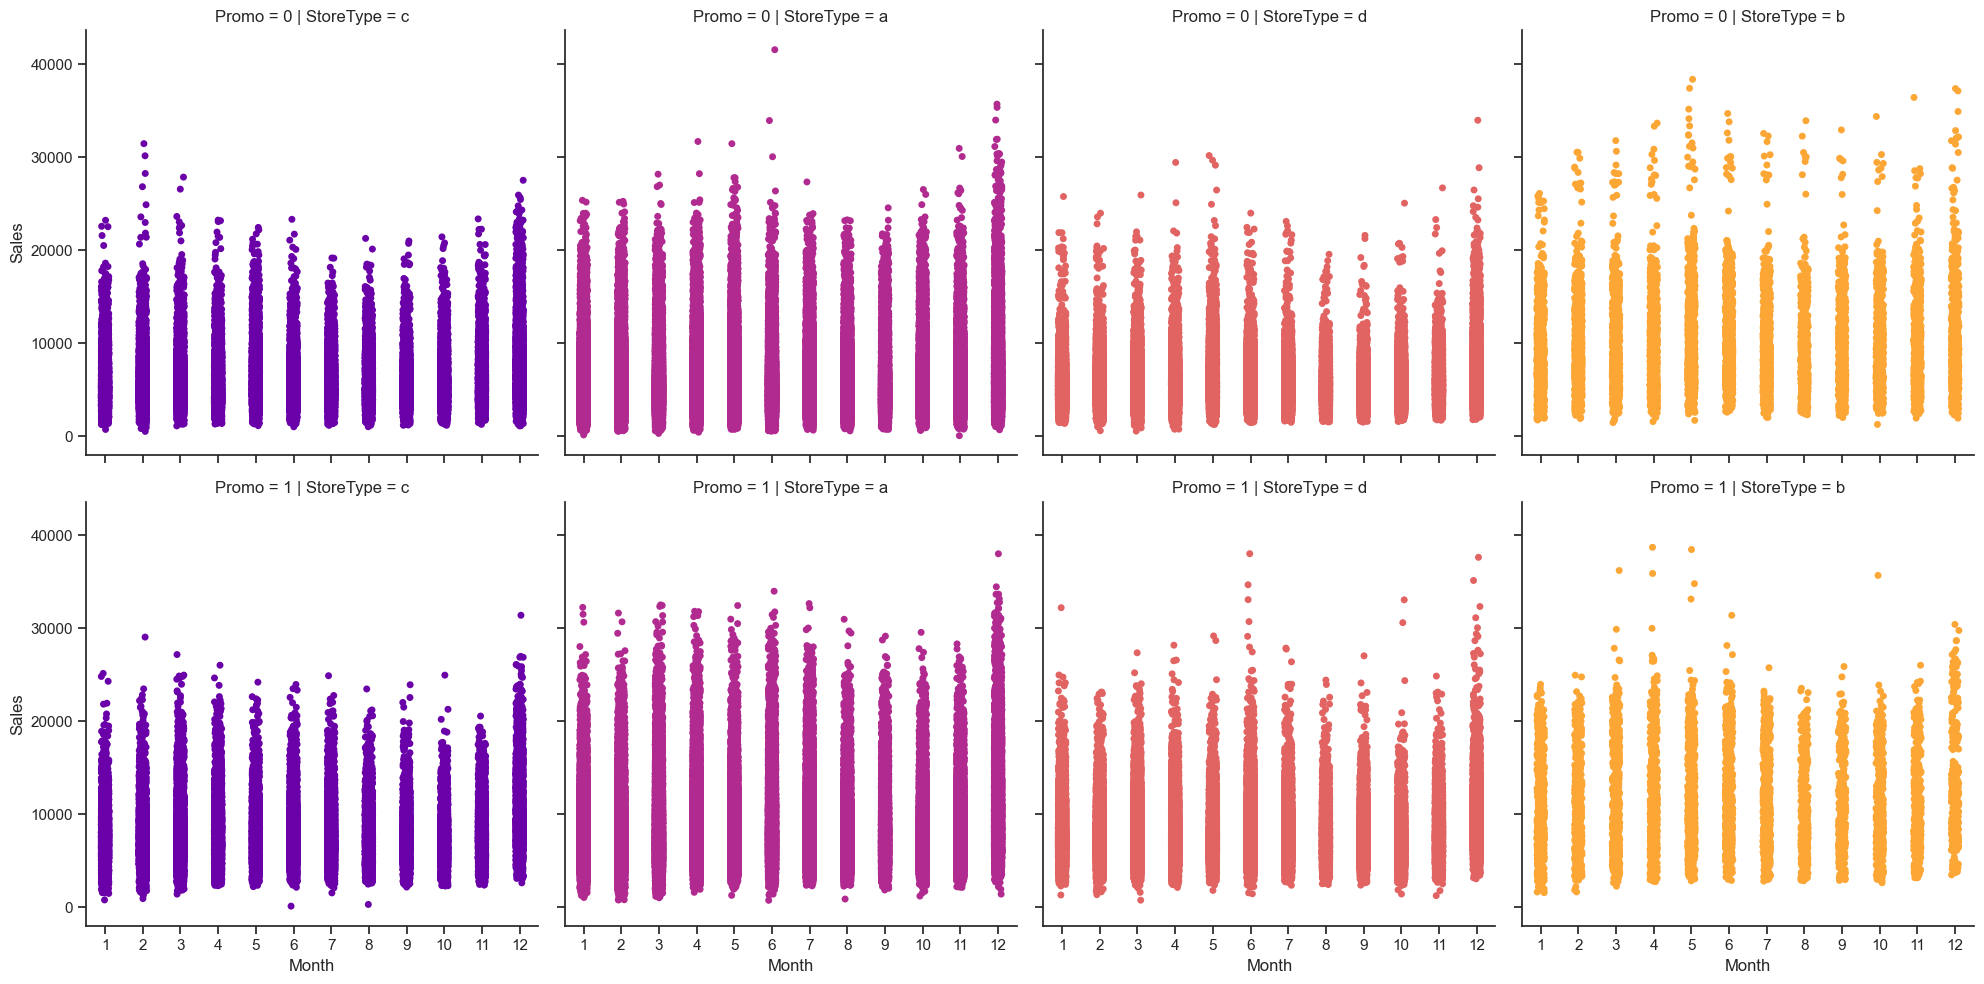

In [75]:
# sales trends
sns.catplot(data=train_store, x='Month', y='Sales', 
            col='StoreType',  # per store type in cols
            palette='plasma',
            hue='StoreType',
            row='Promo',  # per promo in the store in rows
            color=c)

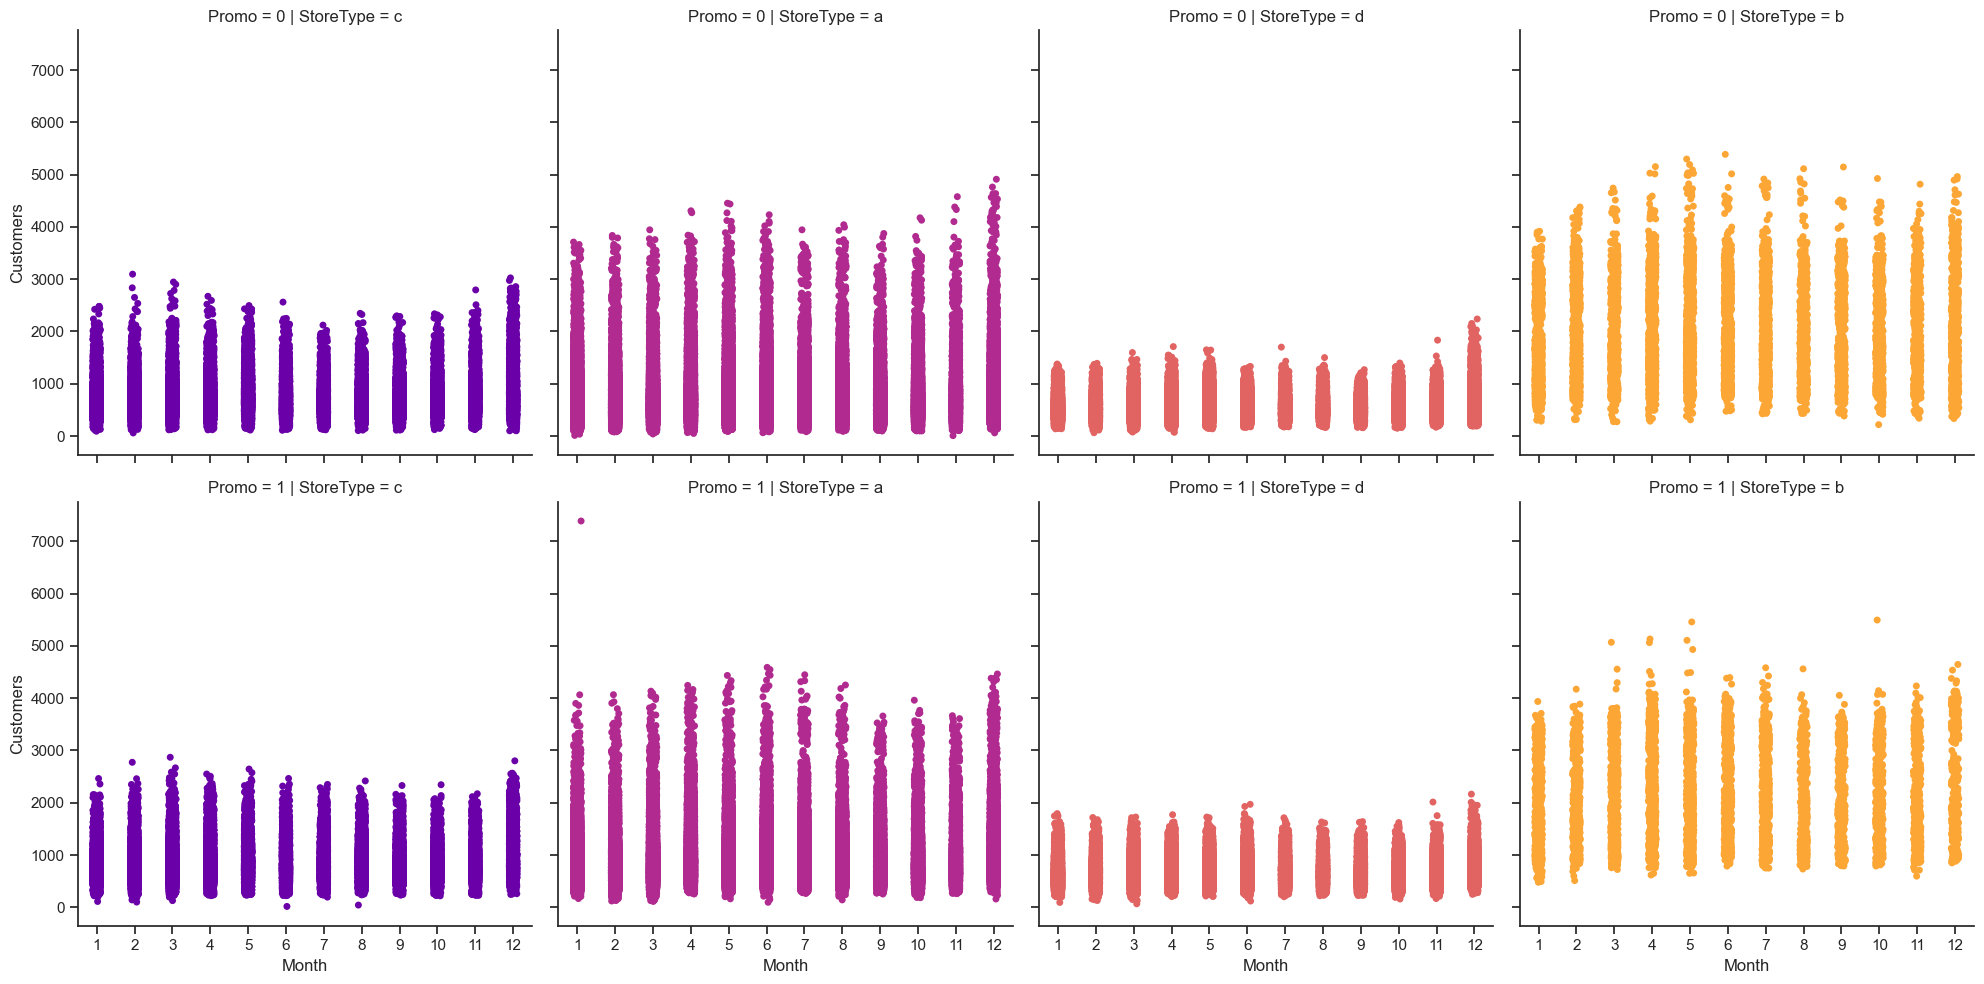

In [76]:
sns.catplot(data = train_store, x = 'Month', y = "Customers", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo', 
               color = c)

All store types follow the same trend but at different scales depending on the presence of the (first) promotion Promo and StoreType itself (case for B).

**Already at this point, we can see that Sales escalate towards Christmas holidays. But we'll talk about seasonalities and trends later in the Time Series Analysis section.**

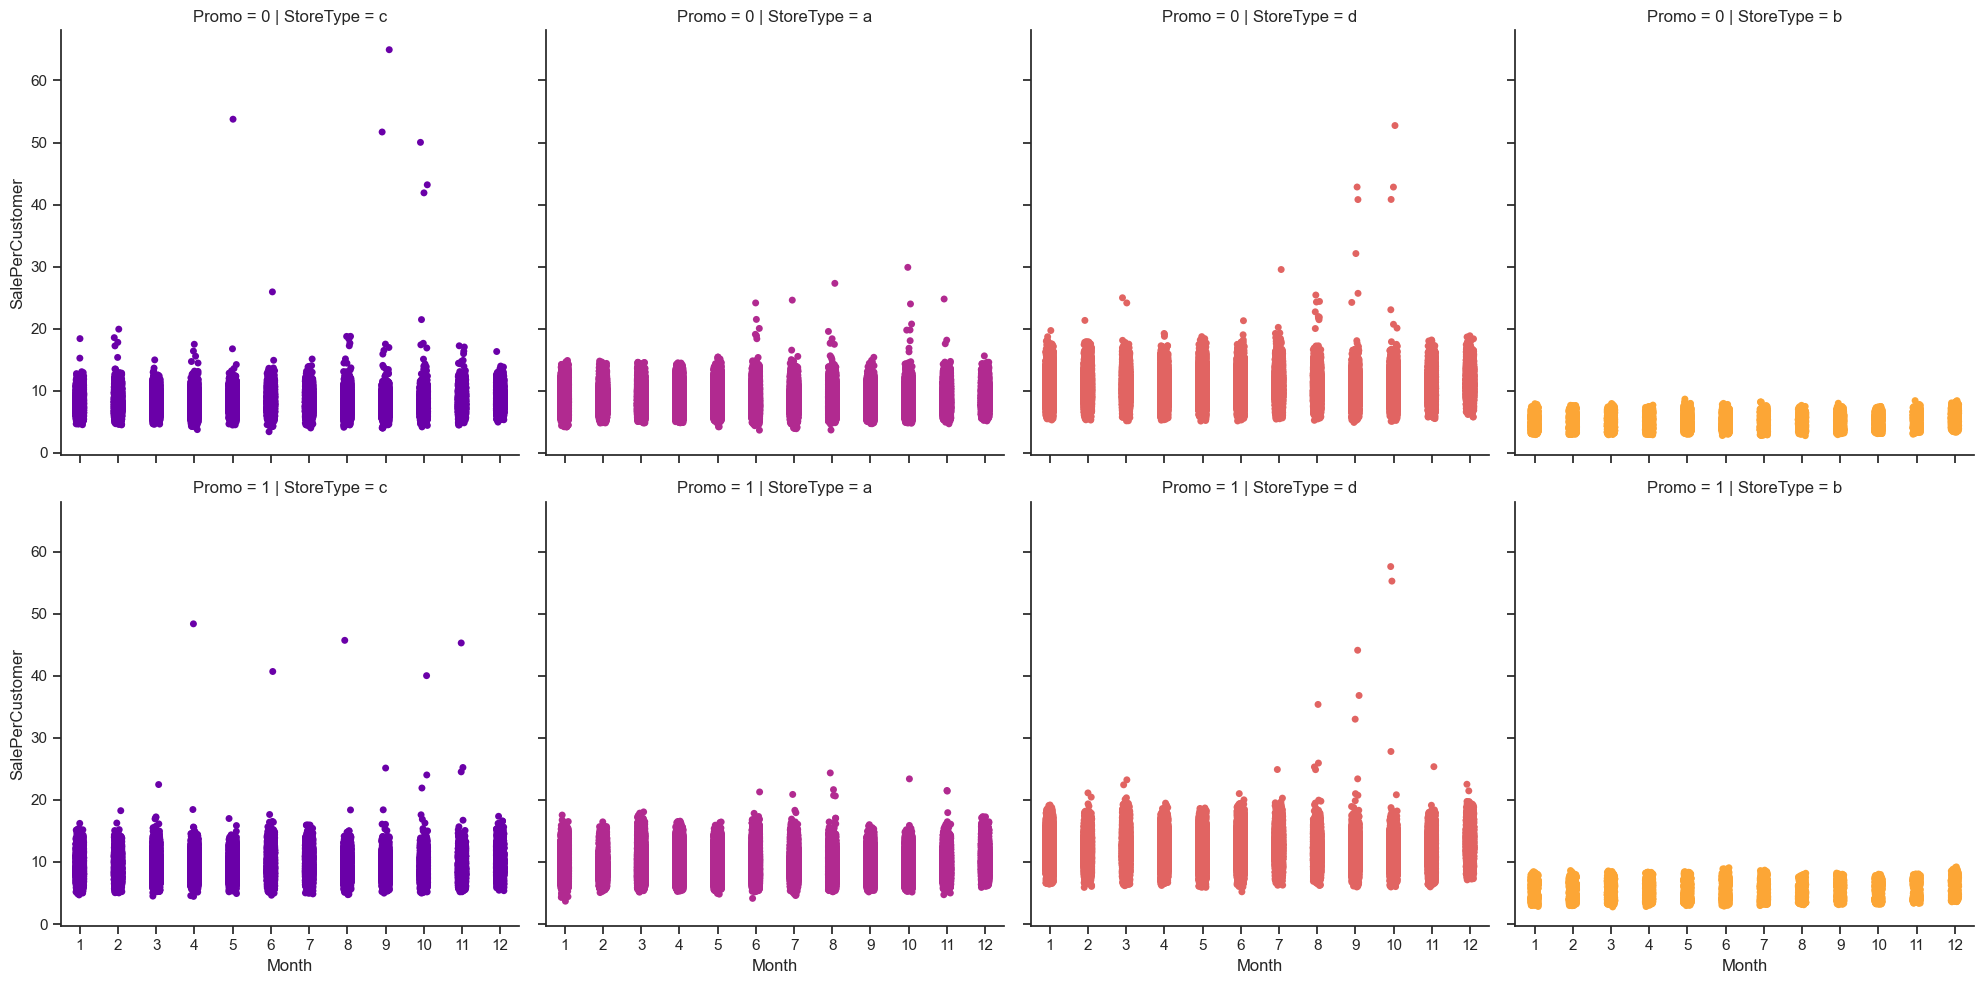

In [77]:
# sale per customer trends
sns.catplot(data = train_store, x = 'Month', y = "SalePerCustomer", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo', # per promo in the store in rows
               color = c)

Eventhough the plots above showed StoreType B as the most selling and performant one, in reality it is not true. The highest SalePerCustomer amount is observed at the StoreType D.

Low SalePerCustomer amount for StoreType B describes its Buyer Cart: there are a lot of people who shop essentially for "small" things (or in a little quantity). Plus we saw that overall this StoreType generated the least amount of sales and customers over the period.

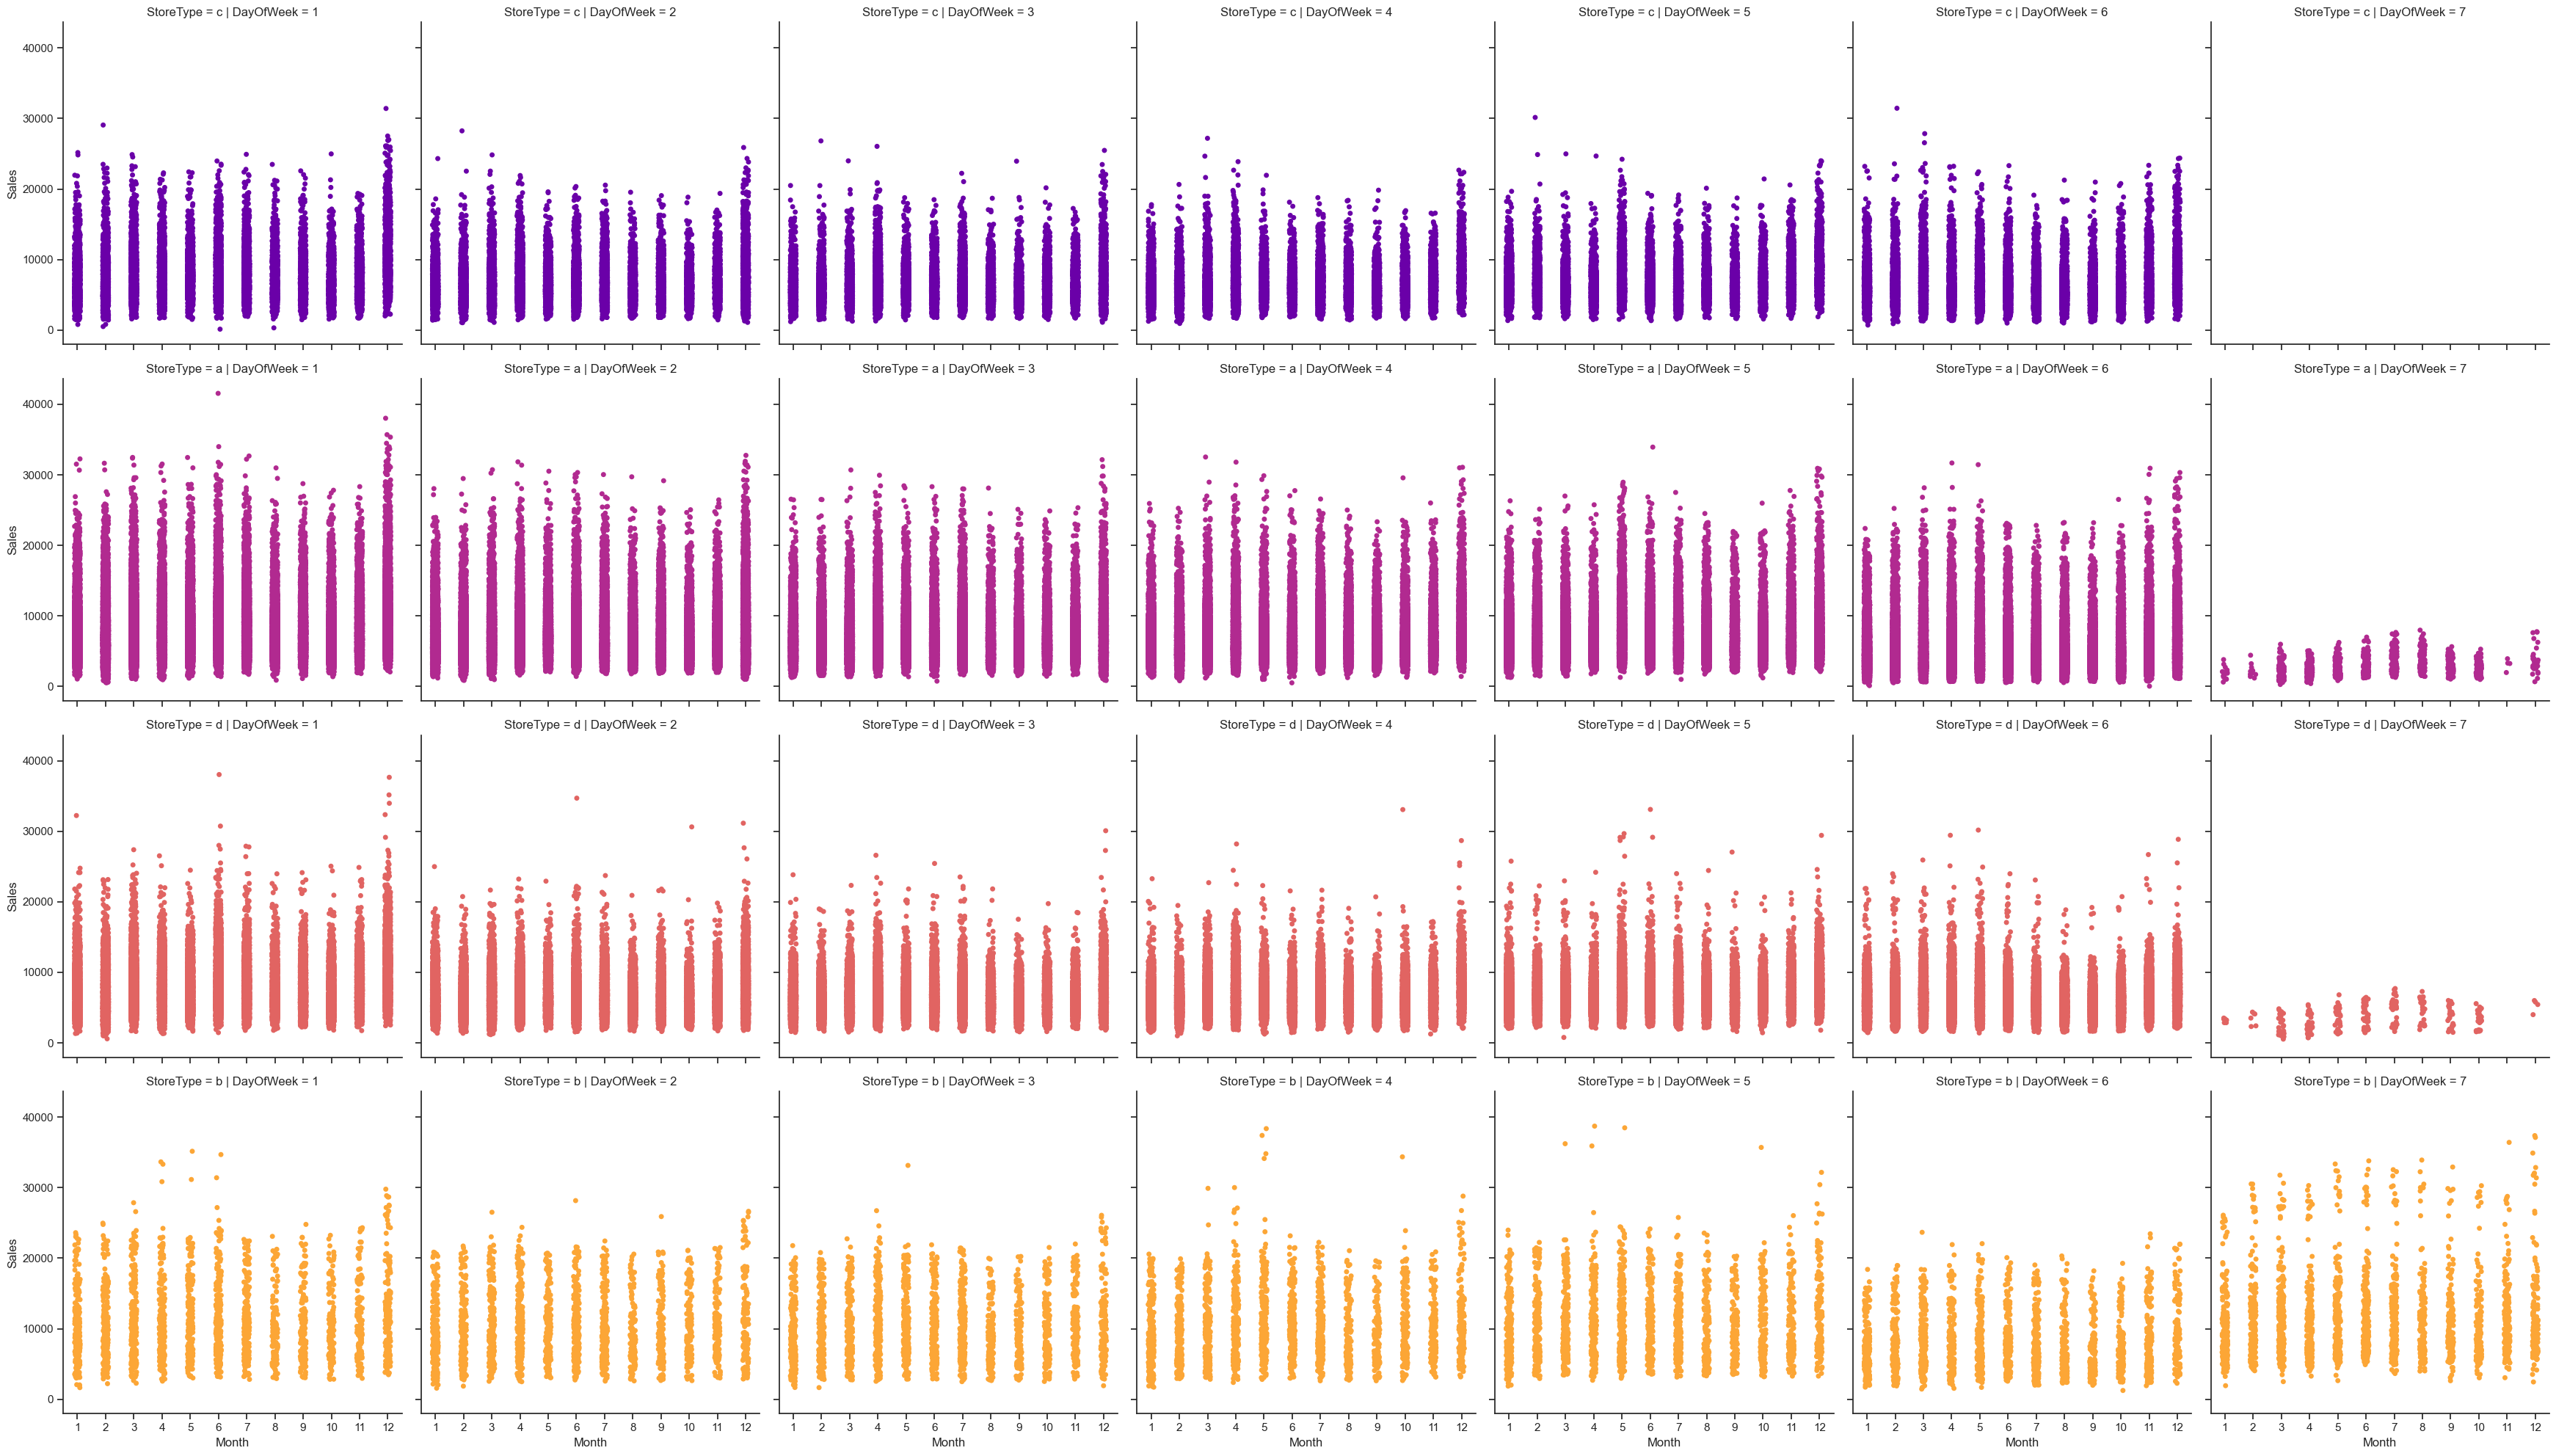

In [78]:
# customers
sns.catplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'DayOfWeek', # per store type in cols
               palette = 'plasma', 
               hue = 'StoreType',
               row = 'StoreType', # per store type in rows
               color = c)

We see that stores of StoreType C are all closed on Sundays, whereas others are most of the time opened. Interestingly enough, stores of StoreType D are closed on Sundays only from October to December.

Bt the way what are the stores which are opened on Sundays?

In [79]:
# stores which are opened on Sundays
train_store[(train_store.Open == 1) & (train_store.DayOfWeek == 7)]['Store'].unique()

array([  85,  122,  209,  259,  262,  274,  299,  310,  335,  353,  423,
        433,  453,  494,  512,  524,  530,  562,  578,  676,  682,  732,
        733,  769,  863,  867,  877,  931,  948, 1045, 1081, 1097, 1099],
      dtype=int64)

To complete our preliminary data analysis, we can add variables describing the period of time during which competition and promotion were opened:

In [80]:
# competition open time (in months)
train_store['CompetitionOpen'] = 12 * (train_store.Year - train_store.CompetitionOpenSinceYear) + \
        (train_store.Month - train_store.CompetitionOpenSinceMonth)
    
# Promo open time
train_store['PromoOpen'] = 12 * (train_store.Year - train_store.Promo2SinceYear) + \
        (train_store.WeekOfYear - train_store.Promo2SinceWeek) / 4.0

# replace NA's by 0
train_store.fillna(0, inplace = True)

# average PromoOpen time and CompetitionOpen time per store type
train_store.loc[:, ['StoreType', 'Sales', 'Customers', 'PromoOpen', 'CompetitionOpen']].groupby('StoreType').mean()

Sales    Customers     PromoOpen  CompetitionOpen
StoreType                                                          
a           6925.697986   795.422370  12918.492198      7115.514452
b          10233.380141  2022.211825  17199.328069     11364.495244
c           6933.126425   815.538073  12158.636107      6745.418694
d           6822.300064   606.353935  10421.916846      9028.526526

The most selling and crowded StoreType A doesn't appear to be the one the most exposed to competitors. Instead it's a StoreType B, which also has the longest running period of promotion.

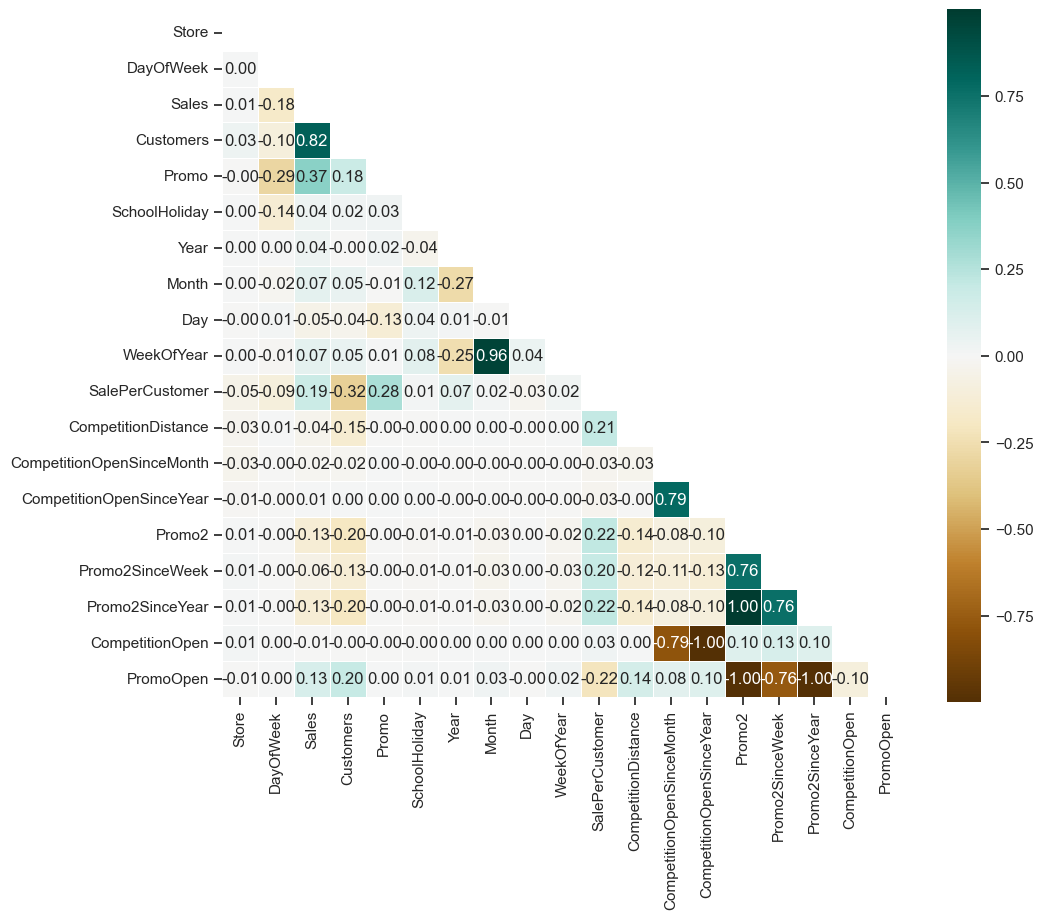

In [81]:
# HeatMap
# Compute the correlation matrix 
# exclude 'Open' variable
corr_all = train_store.drop('Open', axis = 1).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_all, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all, mask = mask, annot = True, square = True, linewidths = 0.5, ax = ax, cmap = "BrBG", fmt='.2f')      
plt.show()

As mentioned before, we have a strong positive correlation between the amount of Sales and Customers of a store. We can also observe a positive correlation between the fact that the store had a running promotion (Promo equal to 1) and amount of Customers.

However, as soon as the store continues a consecutive promotion (Promo2 equal to 1) the number of Customers and Sales seems to stay the same or even decrease, which is described by the pale negative correlation on the heatmap. The same negative correlation is observed between the presence of the promotion in the store and the day of a week.

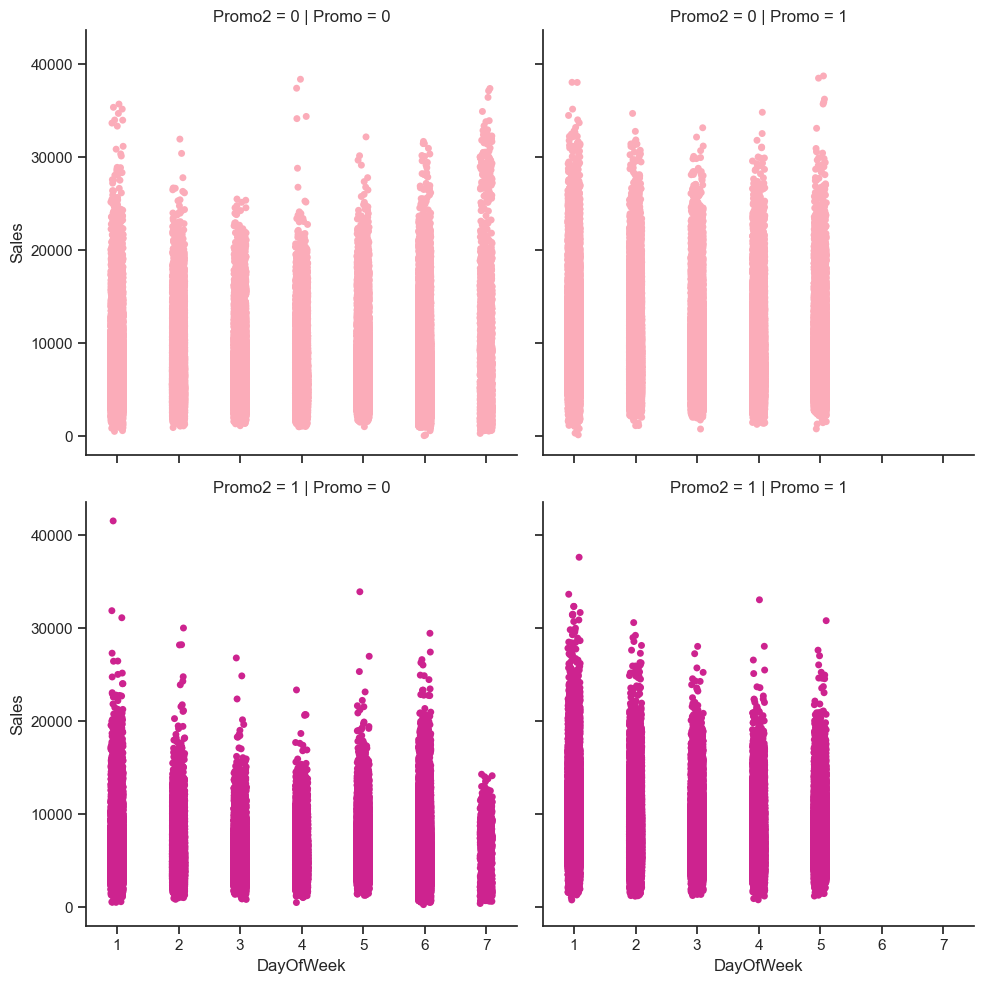

In [83]:
# sale per customer trends
sns.catplot(data = train_store, x = 'DayOfWeek', y = "Sales", 
               col = 'Promo', 
               row = 'Promo2',
               hue = 'Promo2',
               palette = 'RdPu')

**There are several things here**:

In case of no promotion, both Promo and Promo2 are equal to 0, Sales tend to peak on Sunday (!). Though we should note that StoreType C doesn't work on Sundays. So it is mainly data from StoreType A, B and D. On the contrary, stores that run the promotion tend to make most of the Sales on Monday. This fact could be a good indicator for Rossmann marketing campaigns. The same trend follow the stores which have both promotion at the same time (Promo and Promo2 are equal to 1). Promo2 alone doesn't seem to be correlated to any significant change in the Sales amount. This can be also prooved by the blue pale area on the heatmap above.

**Conclusion of EDA**
-The most selling and crowded StoreType is A.
-The best "Sale per Customer" StoreType D indicates to the higher Buyer Cart. We could also assume that the stores of this types are situated in the rural areas, so that customers prefer buying more but less often.
-Low SalePerCustomer amount for StoreType B indicates to the possible fact that people shop there essentially for small things.  Which can also indicate to the label of this store type - "urban" - as it's more accessible for public, and customers don't mind shopping there from time to time during a week.
-Customers tends to buy more on Mondays when there's one promotion running (Promo) and on Sundays when there is no promotion at all (both Promo and Promo1 are equal to 0).
-Promo2 alone doesn't seem to be correlated to any significant change in the Sales amount.

# Time-Series Analysis per Store Type


ARIMA is one of the most classic time series forecasting models. During the modeling process, we mainly want to find 3 parameters. Auto-regression(AR) term, namly the lags of previous value; Integral(I) term for non-stationary differencing and Moving Average(MA) for error term. In this section, we will analyse time series data: its trends, sesonalities and autocorrelation. Usually at the end of the analysis, we are able to develop a seasonal ARIMA (Autoregression Integrated Moving Average) model

**Seasonality**

**We take four stores from store types to represent their group:**



-Store number 2 for StoreType A

-Store number 85 for StoreType B

-Store number 1 for StoreType C

-Store number 13 for StoreType D

**It also makes sense to downsample the data from days to weeks using the resample method to see the present trends more clearly.**

In [86]:
train_store.head()

Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
0      1          5   5263        555     1      1            0   
1      1          4   5020        546     1      1            0   
2      1          3   4782        523     1      1            0   
3      1          2   5011        560     1      1            0   
4      1          1   6102        612     1      1            0   

   SchoolHoliday  Year  Month  ...  Assortment  CompetitionDistance  \
0              1  2015      7  ...           a               1270.0   
1              1  2015      7  ...           a               1270.0   
2              1  2015      7  ...           a               1270.0   
3              1  2015      7  ...           a               1270.0   
4              1  2015      7  ...           a               1270.0   

   CompetitionOpenSinceMonth CompetitionOpenSinceYear Promo2  Promo2SinceWeek  \
0                        9.0                   2008.0      0              0.0   
1                        9.0                   2008.0      0              0.0   
2                        9.0                   2008.0      0              0.0   
3                        9.0                   2008.0      0              0.0   
4                        9.0                   2008.0      0              0.0   

   Promo2SinceYear  PromoInterval  CompetitionOpen  PromoOpen  
0              0.0              0             82.0   24187.75  
1              0.0              0             82.0   24187.75  
2              0.0              0             82.0   24187.75  
3              0.0              0             82.0   24187.75  
4              0.0              0             82.0   24187.75  

[5 rows x 24 columns]

<Axes: xlabel='Date'>

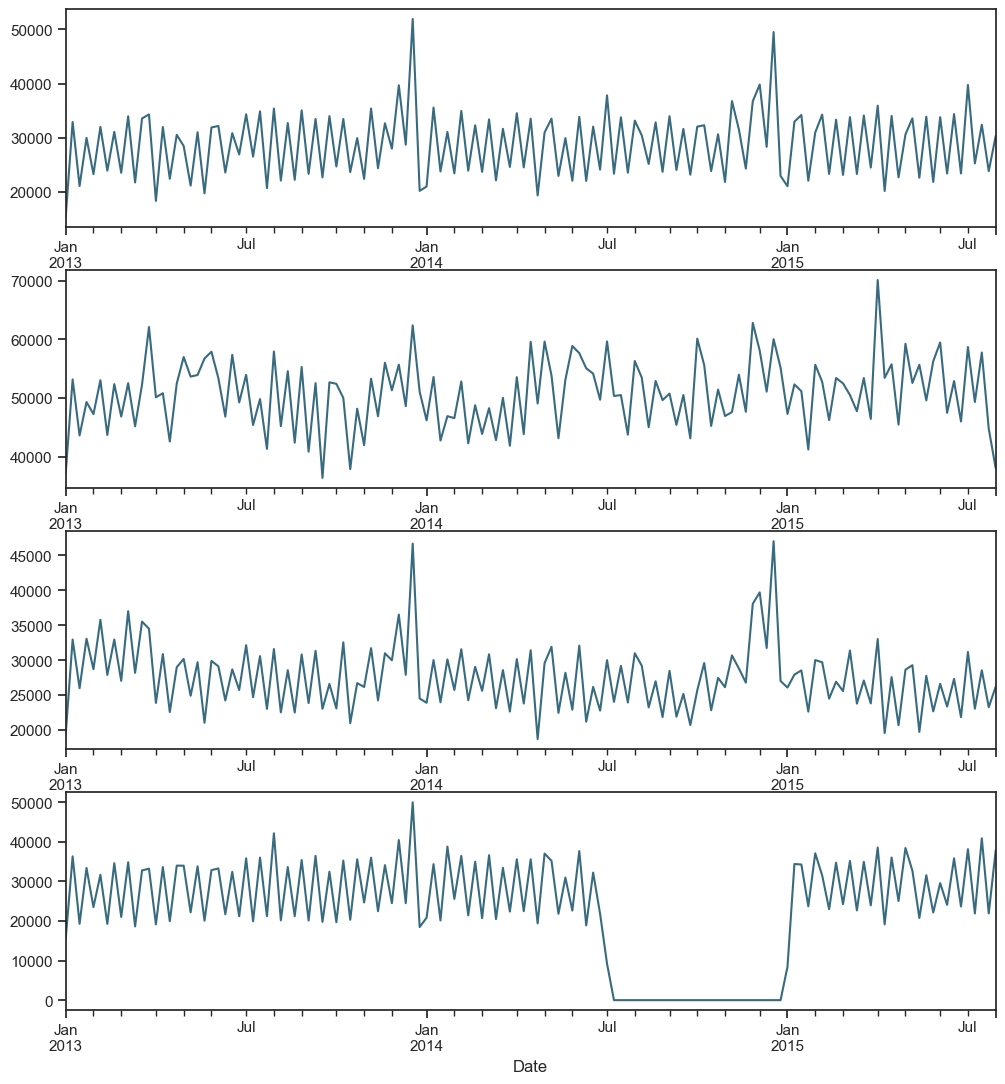

In [87]:
# preparation: input should be float type
train['Sales'] = train['Sales'] * 1.0

# store types
sales_a = train[train.Store == 2]['Sales']
sales_b = train[train.Store == 85]['Sales']
sales_c = train[train.Store == 1]['Sales']
sales_d = train[train.Store == 13]['Sales']

f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

# store types
sales_a.resample('W').sum().plot(color = c, ax = ax1)
sales_b.resample('W').sum().plot(color = c, ax = ax2)
sales_c.resample('W').sum().plot(color = c, ax = ax3)
sales_d.resample('W').sum().plot(color = c, ax = ax4)

Retail sales for StoreType A and C tend to peak for the Christmas season and then decline after the holidays. We might have seen the same trend for StoreType D (at the bottom) but there is no information from July 2014 to January 2015 about these stores as they were closed.

**Yearly trend:**
The next thing to check the presence of a trend in series. Another tool to visualize the data is the seasonal_decompose function in statsmodel. With this, the trend and seasonality become even more obvious.

In [89]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose


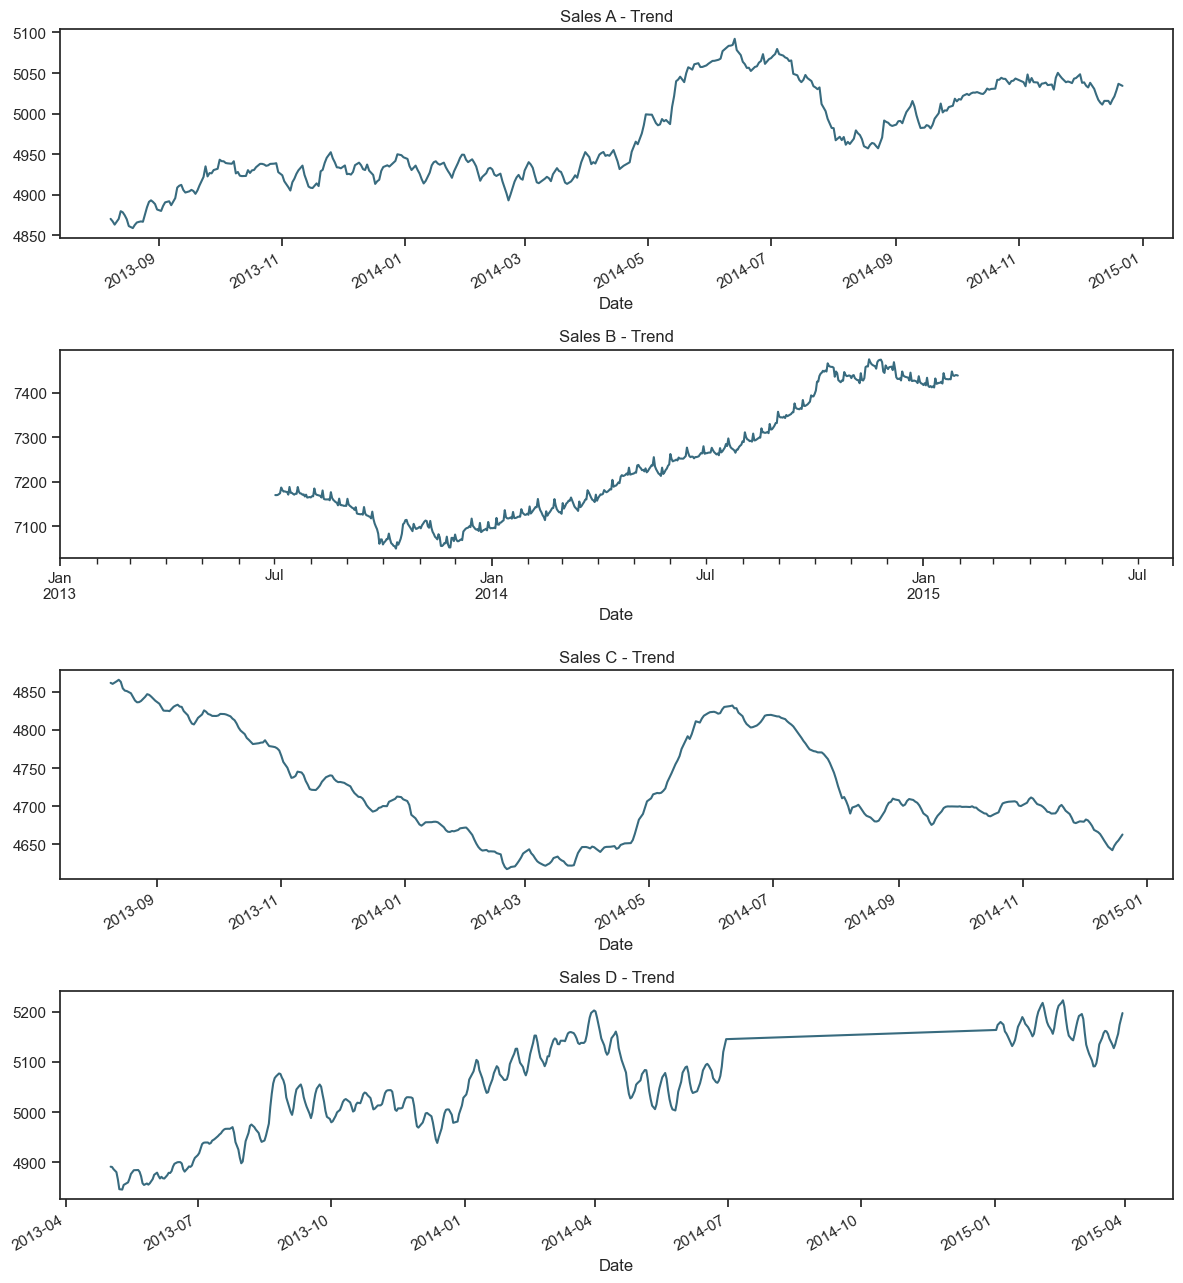

In [92]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Assuming you have defined sales_a, sales_b, sales_c, and sales_d DataFrames/Series
# Also, assuming c is defined as the color you want to use

# Create subplots
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(12, 13))

# Monthly decomposition for sales_a
decomposition_a = seasonal_decompose(sales_a, model='additive', period=365)
decomposition_a.trend.plot(color=c, ax=ax1)
ax1.set_title('Sales A - Trend')

# Monthly decomposition for sales_b
decomposition_b = seasonal_decompose(sales_b, model='additive', period=365)
decomposition_b.trend.plot(color=c, ax=ax2)
ax2.set_title('Sales B - Trend')

# Monthly decomposition for sales_c
decomposition_c = seasonal_decompose(sales_c, model='additive', period=365)
decomposition_c.trend.plot(color=c, ax=ax3)
ax3.set_title('Sales C - Trend')

# Monthly decomposition for sales_d
decomposition_d = seasonal_decompose(sales_d, model='additive', period=200)
decomposition_d.trend.plot(color=c, ax=ax4)
ax4.set_title('Sales D - Trend')

# Customize and show the plot
# Add labels, legends, etc., as needed
plt.tight_layout()
plt.show()

Overall sales seems to increase, however not for the StoreType C (a third from the top). Eventhough the StoreType A is the most selling store type in the dataset, it seems that it cab follow the same decresing trajectory as StoreType C did.

# Stationarize the data:

When running a linear regression the assumption is that all of the observations are all independent of each other. In a time series, however, we know that observations are time dependent. It turns out that a lot of nice results that hold for independent random variables (law of large numbers and central limit theorem to name a couple) hold for stationary random variables. So by making the data stationary, we can actually apply regression techniques to this time dependent variable.

There are two ways you can check the stationarity of a time series. The first is by looking at the data. By visualizing the data it should be easy to identify a changing mean or variation in the data. For a more accurate assessment there is the Dickey-Fuller test.

if the ‘Test Statistic’ is greater than the ‘Critical Value’ than the time series is stationary. Below is code that will help you visualize the time series and test for stationarity.

In [94]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)
    

In [95]:
from scipy import stats
from scipy.stats import normaltest
def residual_plot(model):

    resid = model.resid
    print(normaltest(resid))
    # returns a 2-tuple of the chi-squared statistic, and the associated p-value. the p-value is very small, meaning
    # the residual is not a normal distribution

    fig = plt.figure(figsize=(12,8))
    ax0 = fig.add_subplot(111)

    sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

    # Get the fitted parameters used by the function
    (mu, sigma) = stats.norm.fit(resid)

    #Now plot the distribution using 
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
    plt.ylabel('Frequency')
    plt.title('Residual distribution')


    # ACF and PACF
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(model.resid, lags=40, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(model.resid, lags=40, ax=ax2)

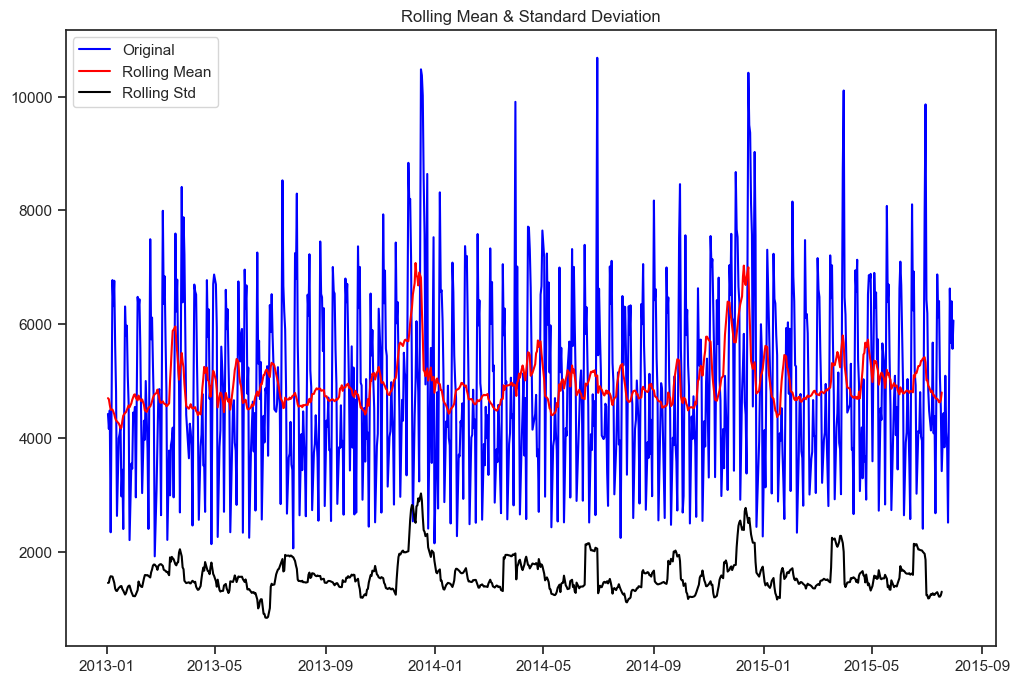

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                  -5.292708
p-value                          0.000006
#Lags Used                      17.000000
Number of Observations Used    766.000000
Critical Value (1%)             -3.438916
Critical Value (5%)             -2.865321
Critical Value (10%)            -2.568783
dtype: float64


In [96]:
test_stationarity(sales_a)

So now we need to transform the data to make it more stationary. There are various transformations you can do to stationarize the data. The first thing we want to do is take a first difference of the data. This should help to eliminate the overall trend from the data.

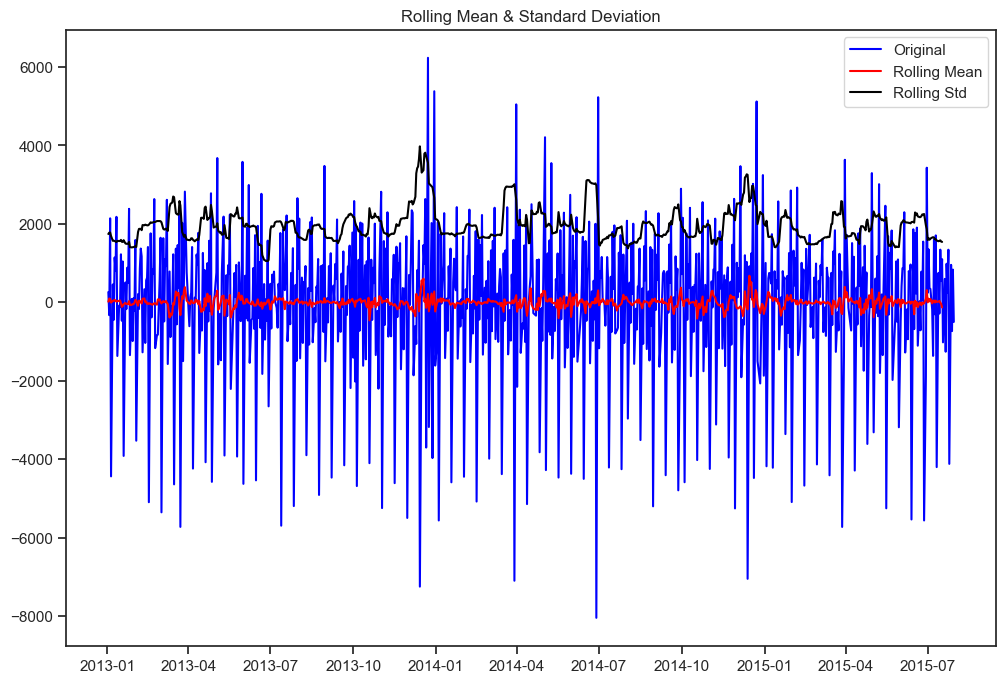

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -1.219964e+01
p-value                        1.231658e-22
#Lags Used                     1.600000e+01
Number of Observations Used    7.660000e+02
Critical Value (1%)           -3.438916e+00
Critical Value (5%)           -2.865321e+00
Critical Value (10%)          -2.568783e+00
dtype: float64


In [97]:
first_diff_a = sales_a - sales_a.shift(1)
first_diff_a = first_diff_a.dropna(inplace = False)
test_stationarity(first_diff_a, window = 12)


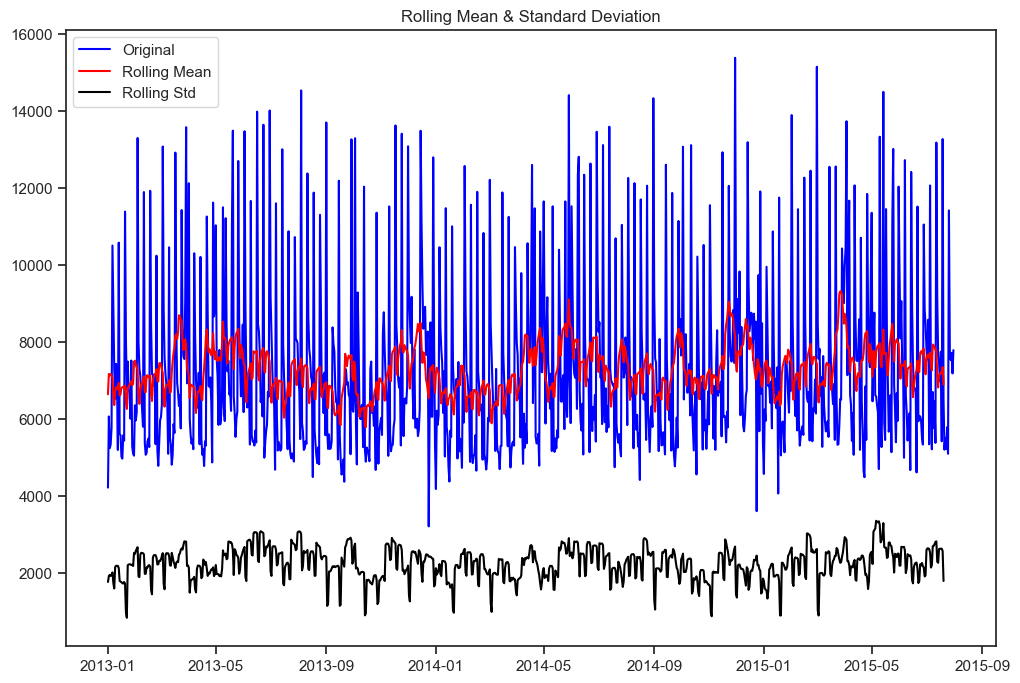

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                  -4.934210
p-value                          0.000030
#Lags Used                      20.000000
Number of Observations Used    921.000000
Critical Value (1%)             -3.437470
Critical Value (5%)             -2.864683
Critical Value (10%)            -2.568444
dtype: float64


In [98]:
test_stationarity(sales_b)


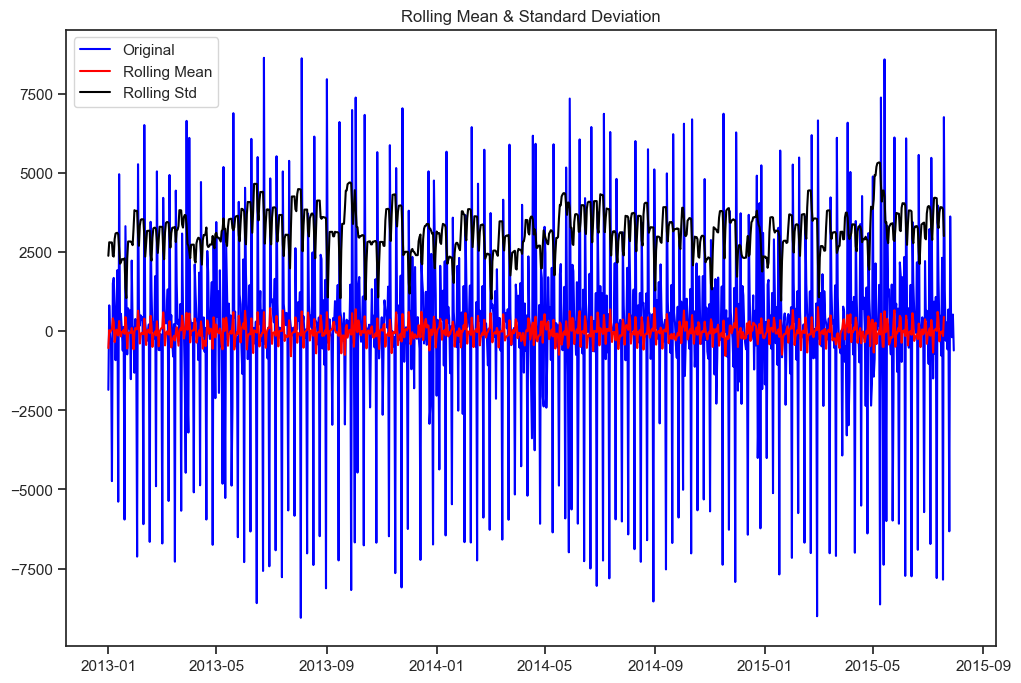

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -1.102941e+01
p-value                        5.718144e-20
#Lags Used                     2.000000e+01
Number of Observations Used    9.200000e+02
Critical Value (1%)           -3.437478e+00
Critical Value (5%)           -2.864687e+00
Critical Value (10%)          -2.568445e+00
dtype: float64


In [99]:
first_diff_b = sales_b - sales_b.shift(1)
first_diff_b = first_diff_b.dropna(inplace = False)
test_stationarity(first_diff_b, window = 12)


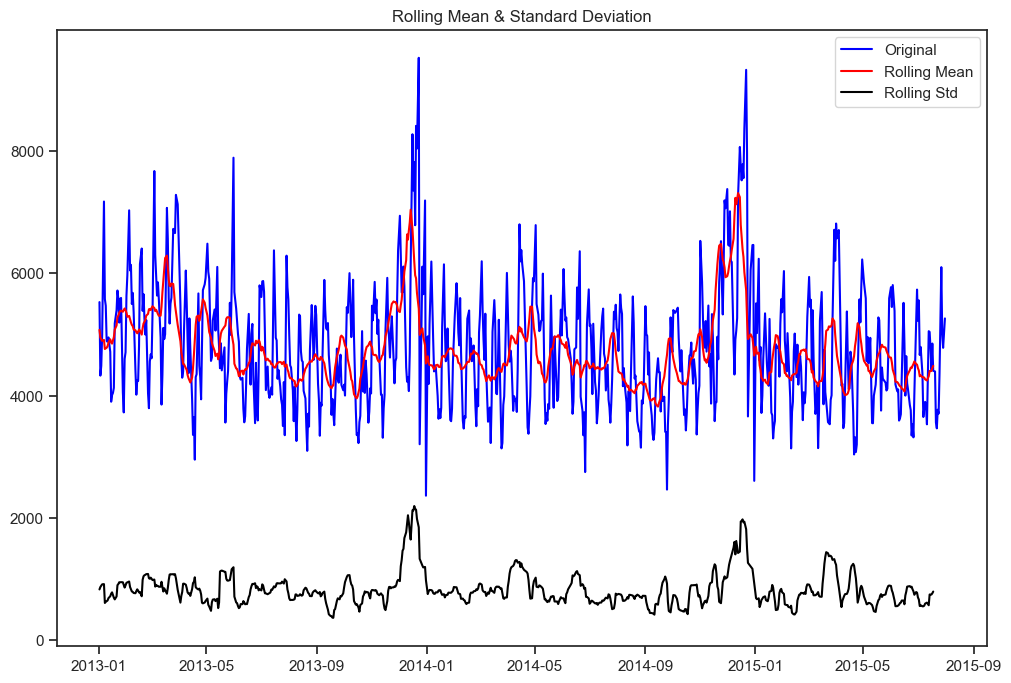

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                  -5.412786
p-value                          0.000003
#Lags Used                      13.000000
Number of Observations Used    767.000000
Critical Value (1%)             -3.438905
Critical Value (5%)             -2.865316
Critical Value (10%)            -2.568781
dtype: float64


In [100]:
test_stationarity(sales_c)

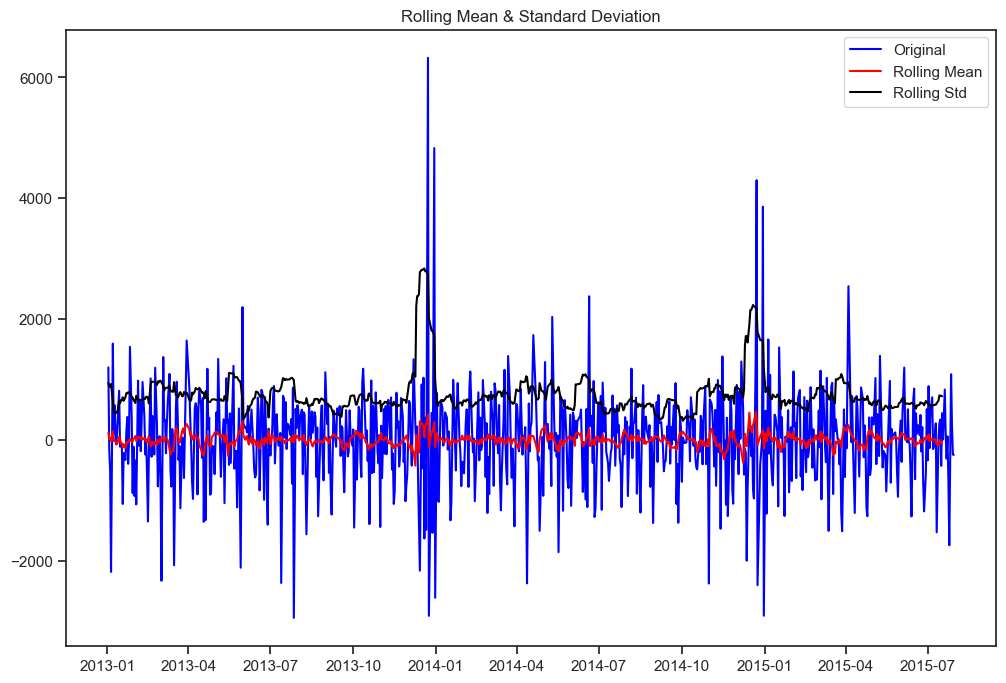

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -1.042084e+01
p-value                        1.706353e-18
#Lags Used                     2.000000e+01
Number of Observations Used    7.590000e+02
Critical Value (1%)           -3.438995e+00
Critical Value (5%)           -2.865355e+00
Critical Value (10%)          -2.568802e+00
dtype: float64


In [101]:
first_diff_c = sales_c - sales_c.shift(1)
first_diff_c = first_diff_c.dropna(inplace = False)
test_stationarity(first_diff_c, window = 12)


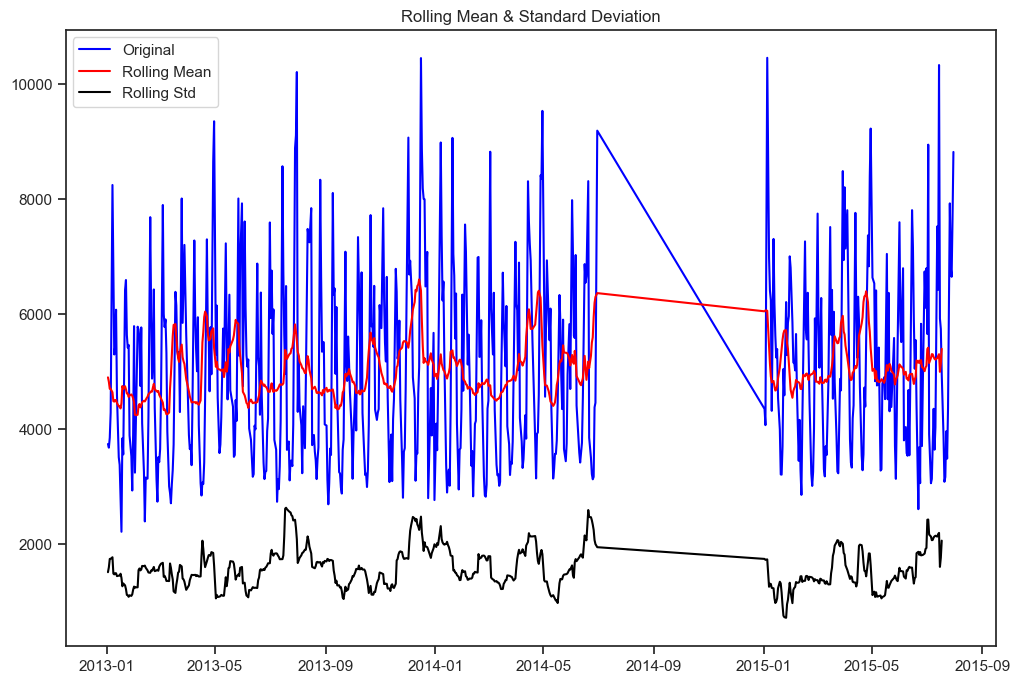

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -6.321001e+00
p-value                        3.066380e-08
#Lags Used                     1.200000e+01
Number of Observations Used    6.080000e+02
Critical Value (1%)           -3.441151e+00
Critical Value (5%)           -2.866305e+00
Critical Value (10%)          -2.569308e+00
dtype: float64


In [102]:
test_stationarity(sales_d)

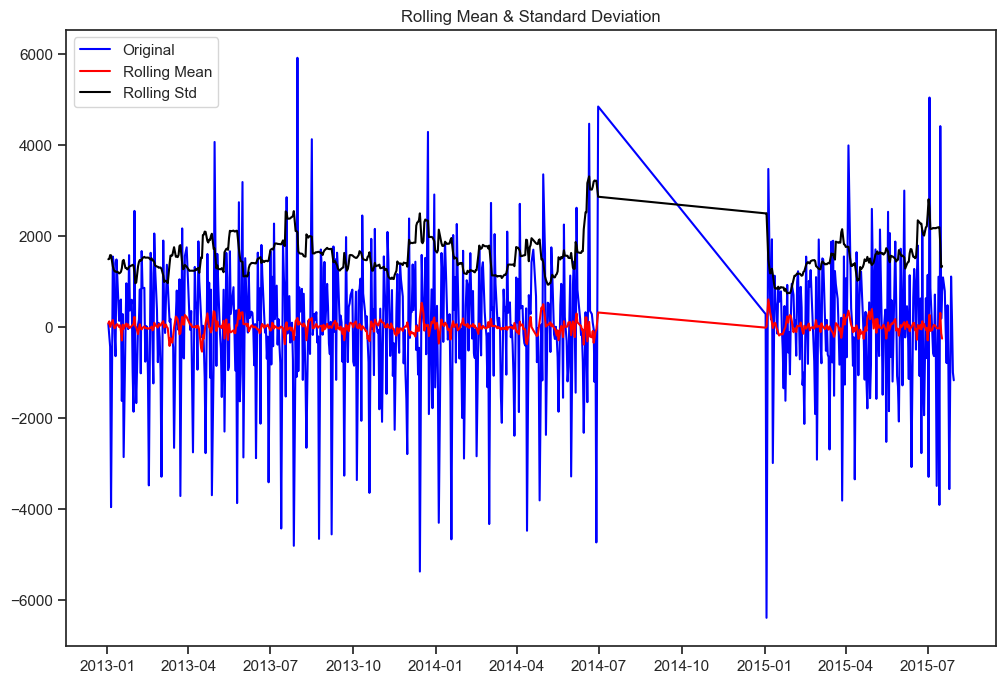

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -9.553455e+00
p-value                        2.535472e-16
#Lags Used                     1.900000e+01
Number of Observations Used    6.000000e+02
Critical Value (1%)           -3.441296e+00
Critical Value (5%)           -2.866369e+00
Critical Value (10%)          -2.569342e+00
dtype: float64


In [103]:
first_diff_d = sales_d - sales_d.shift(1)
first_diff_d = first_diff_d.dropna(inplace = False)
test_stationarity(first_diff_d, window = 12)


# Autocorrelation and partial autocorrelation of data

## **Plot the ACF and PACF charts and find the optimal parameters**

The next step is to determine the tuning parameters of the model by looking at the autocorrelation and partial autocorrelation graphs. There are many rules and best practices about how to select the appropriate AR, MA, SAR, and MAR terms for the model. The chart below provides a brief guide on how to read the autocorrelation and partial autocorrelation graphs to select the proper terms. The big issue as with all models is that you don’t want to overfit your model to the data by using too many terms.

The next step in ourtime series analysis is to review Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots.

**ACF** is a measure of the correlation between the timeseries with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’tn’ with series at instant ‘t1-5’…’tn-5’ (t1-5 and tn being end points).

**PACF**, on the other hand, measures the correlation between the timeseries with a lagged version of itself but after eliminating the variations explained by the intervening comparisons. Eg. at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.

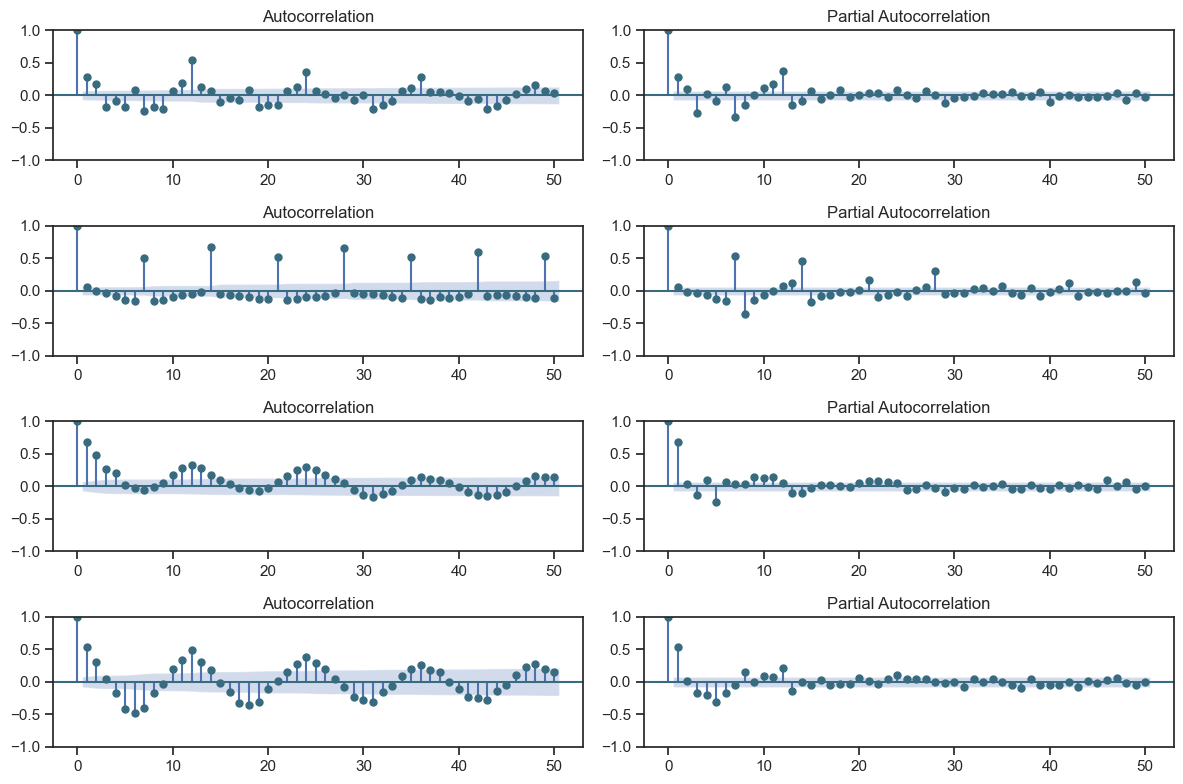

In [105]:

import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Assuming you have defined sales_a, sales_b, sales_c, and sales_d DataFrames/Series
# Also, assuming c is defined as the color you want to use

plt.figure(figsize=(12, 8))

# acf and pacf for A
plt.subplot(421); plot_acf(sales_a, lags=50, ax=plt.gca(), color=c)
plt.subplot(422); plot_pacf(sales_a, lags=50, ax=plt.gca(), color=c)

# acf and pacf for B
plt.subplot(423); plot_acf(sales_b, lags=50, ax=plt.gca(), color=c)
plt.subplot(424); plot_pacf(sales_b, lags=50, ax=plt.gca(), color=c)

# acf and pacf for C
plt.subplot(425); plot_acf(sales_c, lags=50, ax=plt.gca(), color=c)
plt.subplot(426); plot_pacf(sales_c, lags=50, ax=plt.gca(), color=c)

# acf and pacf for D
plt.subplot(427); plot_acf(sales_d, lags=50, ax=plt.gca(), color=c)
plt.subplot(428); plot_pacf(sales_d, lags=50, ax=plt.gca(), color=c)

# Customize and show the plot
# Add labels, legends, etc., as needed
plt.tight_layout()
plt.show()

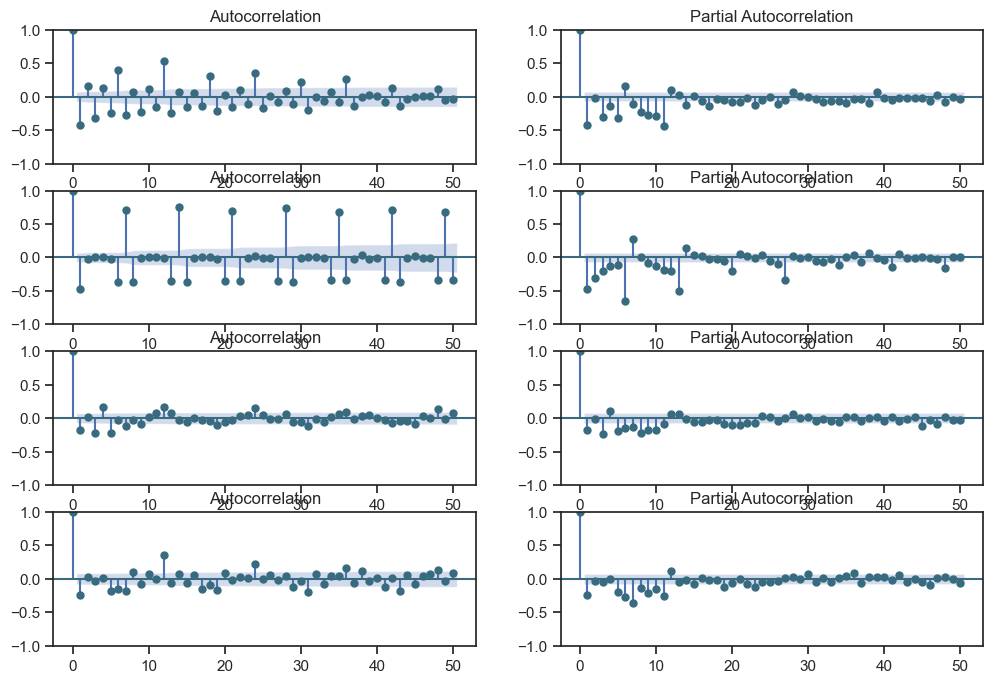

In [106]:
#figure for subplot
plt.figure(figsize = (12, 8))

# acf and pacf for A
plt.subplot(421); plot_acf(first_diff_a, lags = 50, ax = plt.gca(), color = c)
plt.subplot(422); plot_pacf(first_diff_a, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for B
plt.subplot(423); plot_acf(first_diff_b, lags = 50, ax = plt.gca(), color = c)
plt.subplot(424); plot_pacf(first_diff_b, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for C
plt.subplot(425); plot_acf(first_diff_c, lags = 50, ax = plt.gca(), color = c)
plt.subplot(426); plot_pacf(first_diff_c, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for D
plt.subplot(427); plot_acf(first_diff_d, lags = 50, ax = plt.gca(), color = c)
plt.subplot(428); plot_pacf(first_diff_d, lags = 50, ax = plt.gca(), color = c)

plt.show()

We can read these plots horizontally. Each horizontal pair is for one 'StoreType', from A to D. In general, those plots are showing the correlation of the series with itself, lagged by x time units correlation of the series with itself, lagged by x time units.

There is at two things common for each pair of plots: non randomnes of the time series and high lag-1 (which will probably need a higher order of differencing d/D).

Type A and type B: Both types show seasonalities at certain lags. For type A, it is each 12th observation with positives spikes at the 12 (s) and 24(2s) lags and so on. For type B it's a weekly trend with positives spikes at the 7(s), 14(2s), 21(3s) and 28(4s) lags.
Type C and type D: Plots of these two types are more complex. It seems like each observation is coorrelated to its adjacent observations.

# **Build Model:**

How to determin p, d, q It's easy to determin I. In our case, we see the first order differencing make the ts stationary. I = 1.

AR model might be investigated first with lag length selected from the PACF or via empirical investigation. In our case, it's clearly that within 11 lags the AR is significant. Which means, we can use AR = 11

To avoid the potential for incorrectly specifying the MA order (in the case where the MA is first tried then the MA order is being set to 0), it may often make sense to extend the lag observed from the last significant term in the PACF.

In [110]:
import statsmodels.api as sm

# Assuming you have defined sales_a DataFrame/Series and c as the color you want to use

# If sales_a is a DataFrame, you may need to select the 'Sales' column
# endog = sales_a['Sales']

# If sales_a is a Series, you can directly use it
endog = sales_a

# Fit ARIMA model
arima_mod_a = sm.tsa.ARIMA(endog, order=(11, 1, 0)).fit()
print(arima_mod_a.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  784
Model:                ARIMA(11, 1, 0)   Log Likelihood               -6698.797
Date:                Thu, 25 Jan 2024   AIC                          13421.593
Time:                        00:10:26   BIC                          13477.551
Sample:                             0   HQIC                         13443.111
                                - 784                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7256      0.028    -26.155      0.000      -0.780      -0.671
ar.L2         -0.5615      0.030    -18.721      0.000      -0.620      -0.503
ar.L3         -0.6732      0.032    -20.910      0.0

NormaltestResult(statistic=56.099232981984805, pvalue=6.579703726331981e-13)


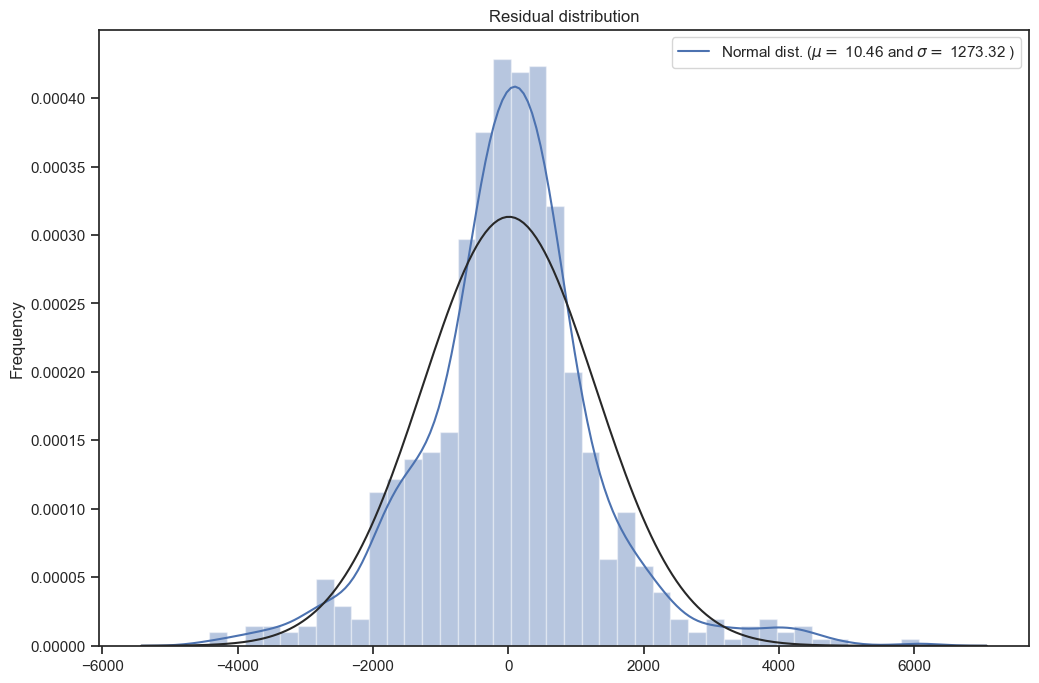

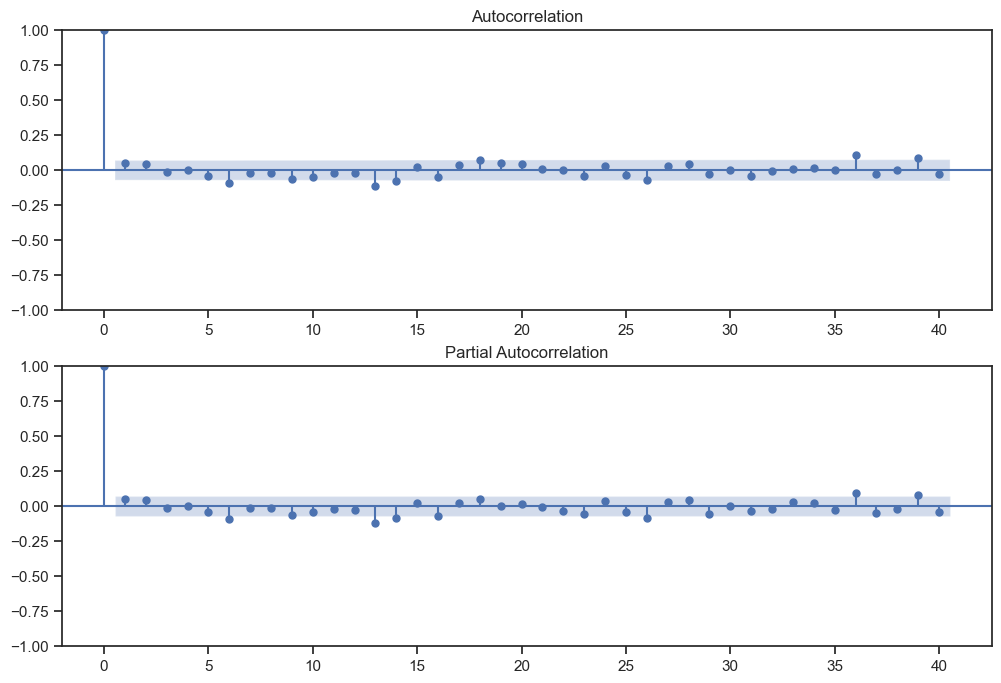

In [111]:
residual_plot(arima_mod_a)

In [112]:
sarima_mod_a = sm.tsa.statespace.SARIMAX(sales_a, trend='n', order=(11,1,0), seasonal_order=(2,1,0,12)).fit()
print(sarima_mod_a.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               Sales   No. Observations:                  784
Model:             SARIMAX(11, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -6650.912
Date:                             Thu, 25 Jan 2024   AIC                          13329.824
Time:                                     00:14:29   BIC                          13394.891
Sample:                                          0   HQIC                         13354.863
                                             - 784                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6446      0.027    -23.711      0.000      -0.698      -0.591
ar.L2         -0.4139      

NormaltestResult(statistic=53.72265246028314, pvalue=2.1591073789252327e-12)


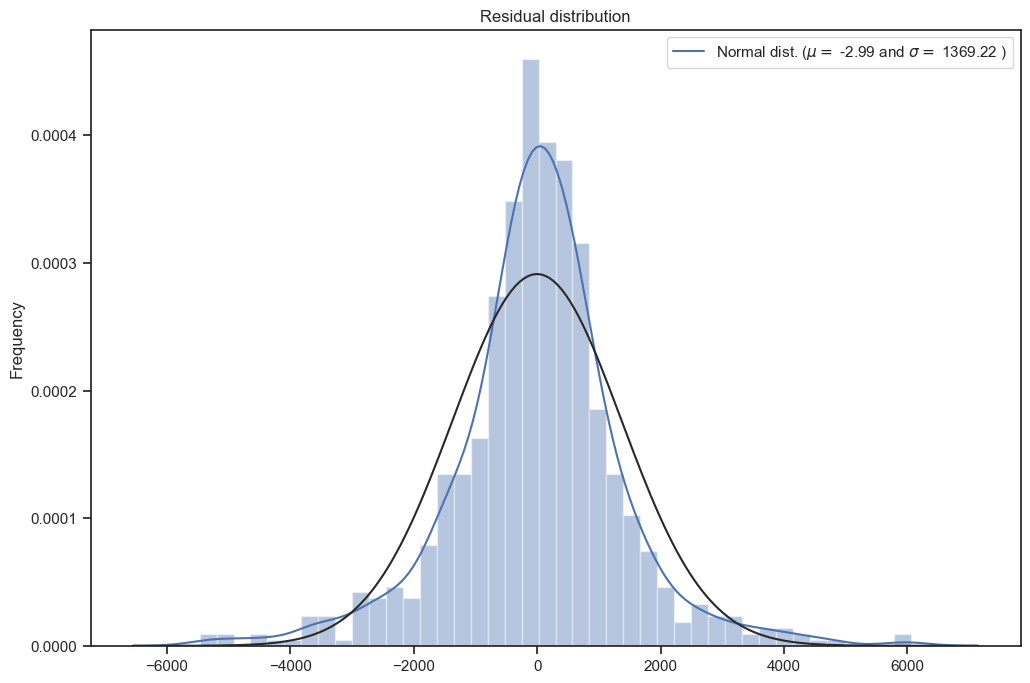

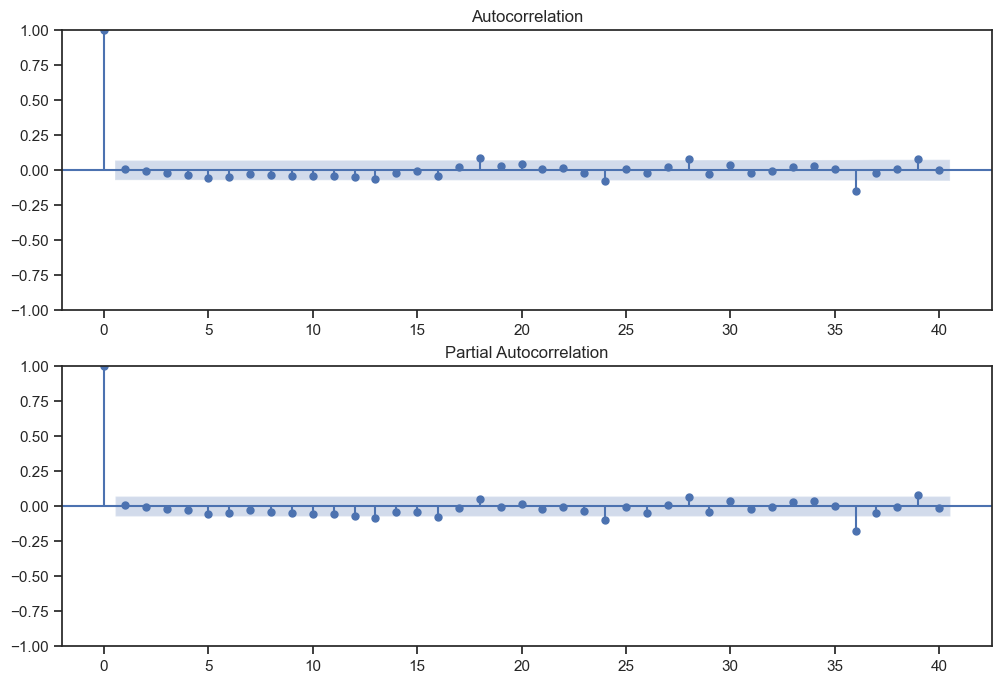

In [113]:
residual_plot(sarima_mod_a)

In [114]:
print(sales_a.shape)
sales_a.head()

(784,)


Date
2015-07-31    6064.0
2015-07-30    5567.0
2015-07-29    6402.0
2015-07-28    5671.0
2015-07-27    6627.0
Name: Sales, dtype: float64

In [115]:
sales_a_reindex = sales_a.reindex(index=sales_a.index[::-1])

In [116]:
sales_a_reindex

Date
2013-01-02    4422.0
2013-01-03    4159.0
2013-01-04    4484.0
2013-01-05    2342.0
2013-01-07    6775.0
               ...  
2015-07-27    6627.0
2015-07-28    5671.0
2015-07-29    6402.0
2015-07-30    5567.0
2015-07-31    6064.0
Name: Sales, Length: 784, dtype: float64

In [117]:
mydata_a = sales_a_reindex
#mydata_a = sales_a_reindex.loc['2013-01-02':'2015-01-21']
#mydata_test = data.loc['2017-01-01':]

In [118]:
print(mydata_a)

Date
2013-01-02    4422.0
2013-01-03    4159.0
2013-01-04    4484.0
2013-01-05    2342.0
2013-01-07    6775.0
               ...  
2015-07-27    6627.0
2015-07-28    5671.0
2015-07-29    6402.0
2015-07-30    5567.0
2015-07-31    6064.0
Name: Sales, Length: 784, dtype: float64


In [119]:
temp_df =pd.DataFrame(mydata_a)

In [120]:
mydata_a = temp_df

In [121]:
sarima_mod_a_train = sm.tsa.statespace.SARIMAX(mydata_a, trend='n', order=(11,1,0), seasonal_order=(2,1,0,12)).fit()
print(sarima_mod_a_train.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               Sales   No. Observations:                  784
Model:             SARIMAX(11, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -6650.967
Date:                             Thu, 25 Jan 2024   AIC                          13329.933
Time:                                     00:18:44   BIC                          13395.001
Sample:                                          0   HQIC                         13354.973
                                             - 784                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6429      0.029    -22.226      0.000      -0.700      -0.586
ar.L2         -0.4115      

NormaltestResult(statistic=90.08657575127071, pvalue=2.741249899932296e-20)


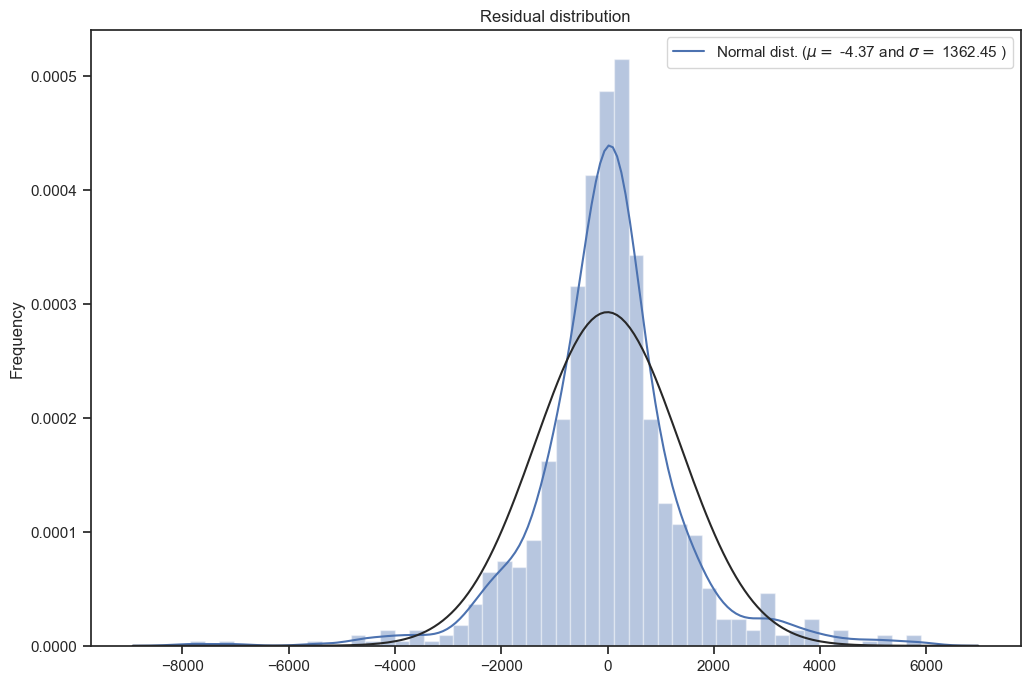

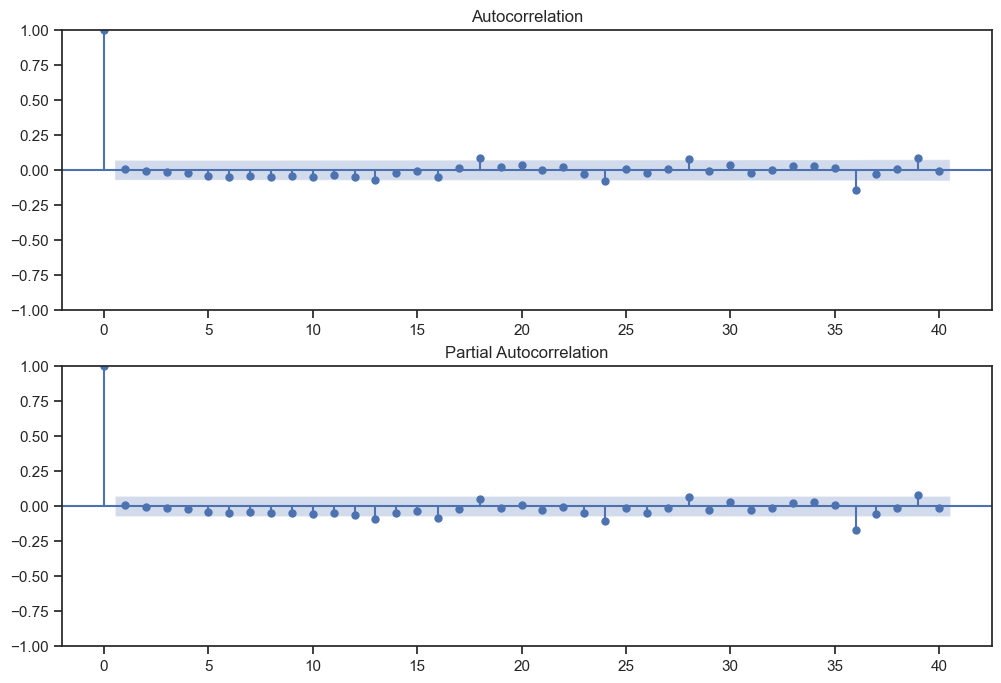

In [123]:
residual_plot(sarima_mod_a_train)

Text(0.5, 0, 'Time')

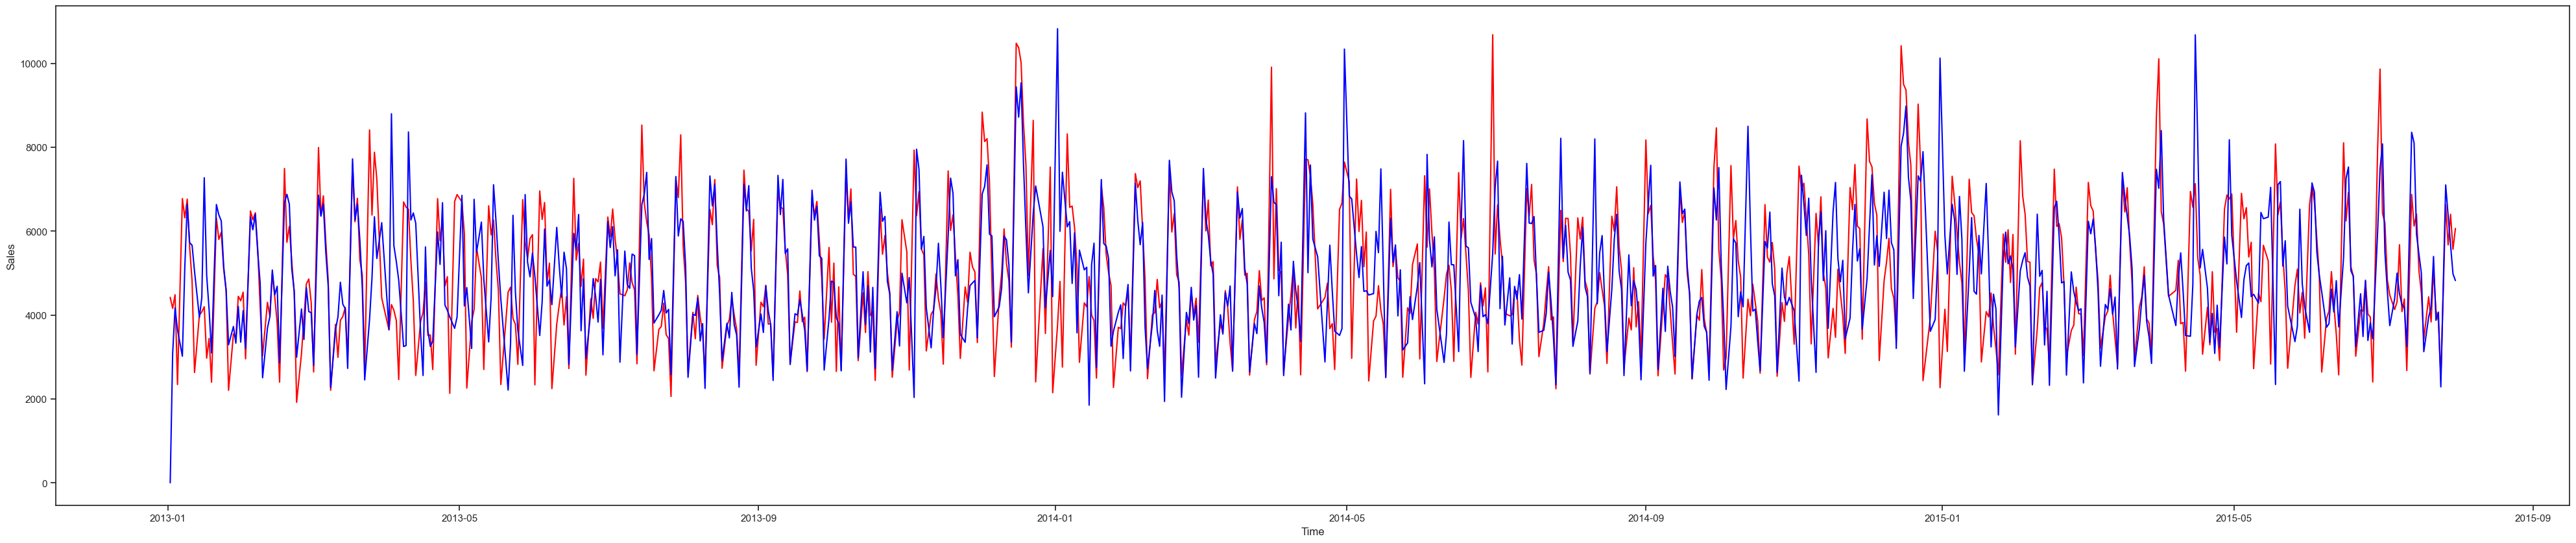

In [124]:
plt.figure(figsize=(50,10))
plt.plot(mydata_a, c='red')
plt.plot(sarima_mod_a_train.fittedvalues, c='blue')
plt.ylabel("Sales")
plt.xlabel("Time")

Date
2015-01-22    4495.673419
2015-01-23    4145.602977
2015-01-24    1617.491690
2015-01-26    5316.759669
2015-01-27    5977.413124
                 ...     
2015-07-27    7101.041815
2015-07-28    6372.795410
2015-07-29    5669.266744
2015-07-30    4981.808443
2015-07-31    4821.878128
Name: predicted_mean, Length: 159, dtype: float64

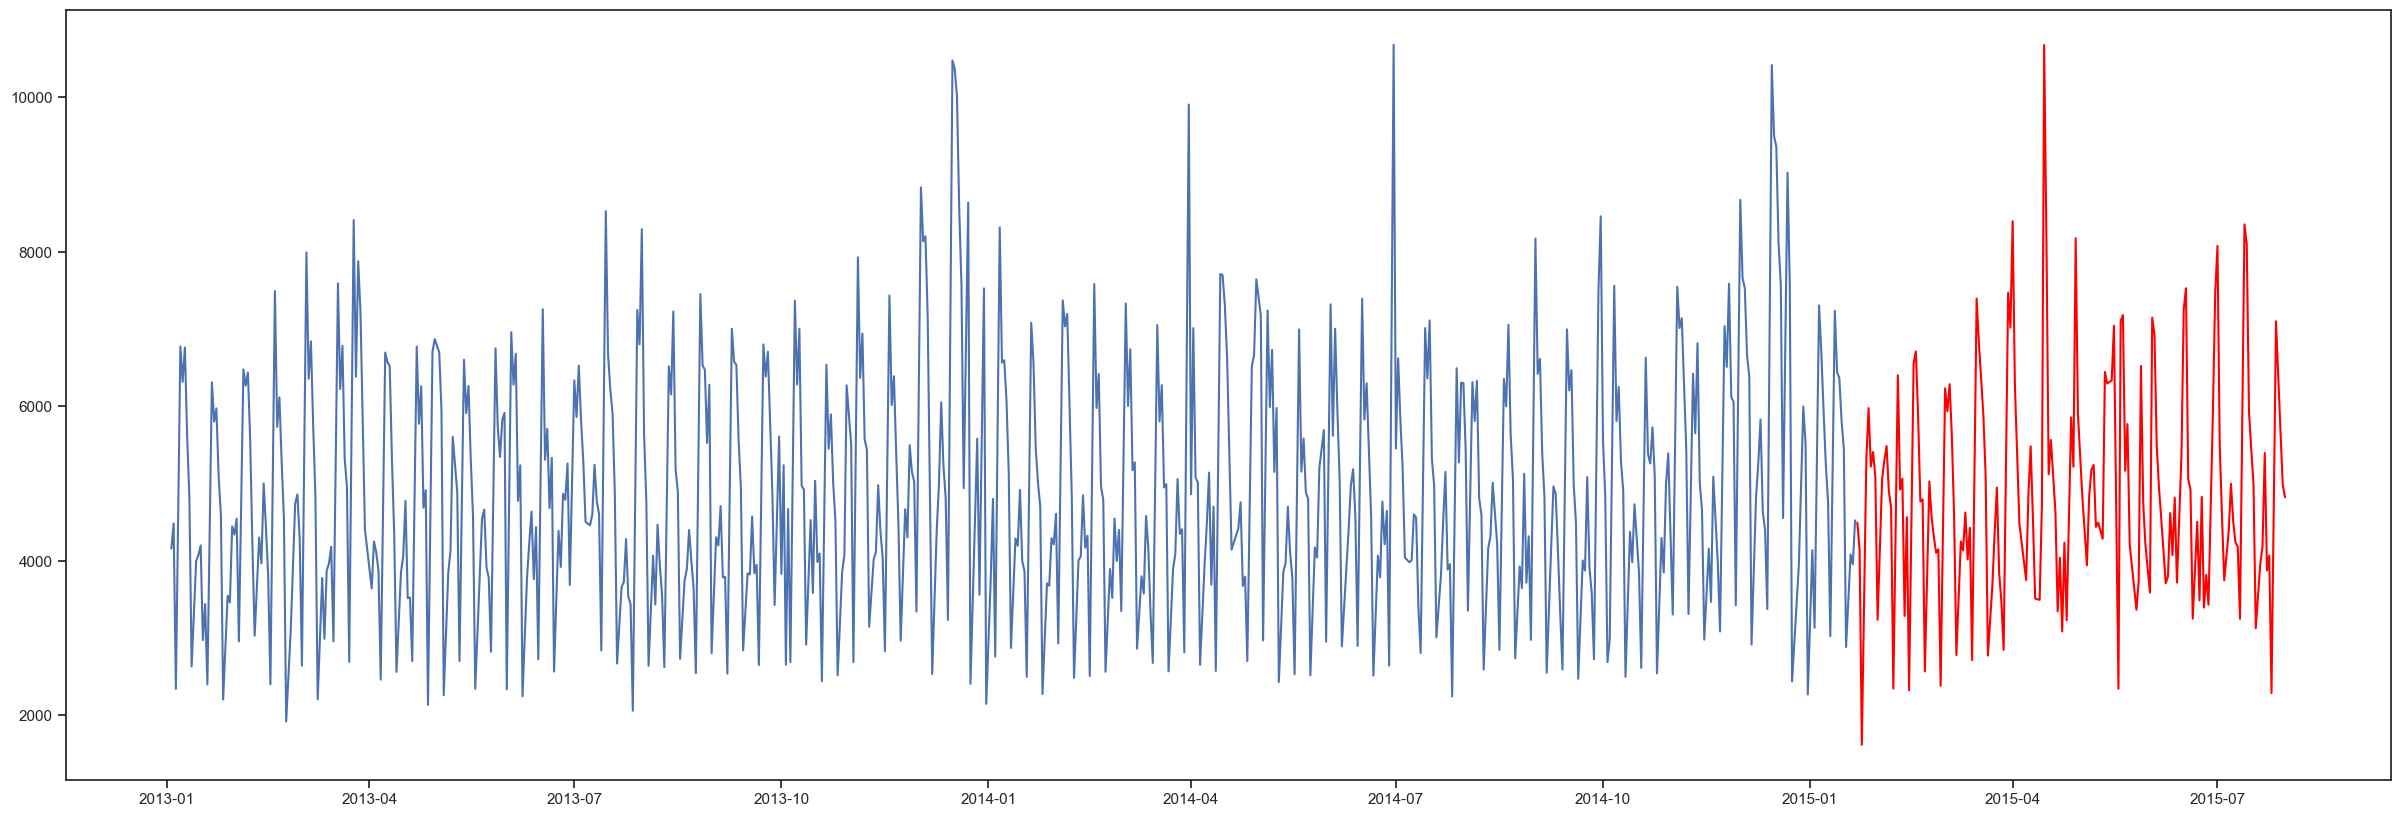

In [125]:
#forecast = sarima_mod_a_train.predict(start =mydata_a.loc['2015-01-21':], dynamic= True)  
#plt.plot(mydata_a.loc['2013-01-02':'2015-01-21'])
plt.figure(figsize=(30,10))
forecast = sarima_mod_a_train.predict(start = 625, end = 783, dynamic= False)  
plt.plot(mydata_a.iloc[1:625])
plt.plot(forecast, c = "red")
forecast
#pred_ci = forecast.conf_int()
#pred_ci.head()

#start_index = 624
#end_index = 784
#mydata_a['forecast'] = sarima_mod_a_train.predict(start = start_index, end= end_index, dynamic= True)  
#mydata_a[start_index:end_index][['sales', 'forecast']].plot(figsize=(12, 8))

# Conclusion

**Pros:**

 Arima can catch interactions between external features, which could improve the forecasting power of a model, But in case of Facebook prophet we cant use interactions term.

Eventhough Prophet offers an automated solution for ARIMA, this methodology is under development and not completely stable.

**Cons**

Fitting seasonal ARIMA model needs 4 to 5 whole seasons in the dataset, which can be the the biggest drawback for new companies.

Seasonal ARIMA in Python has 7 hyperparameters which can be tuned only manually affecting significantly the speed of the forecasting process.